# **Prepare Datasets**

## AWS configuration

In [ ]:
!pip install awscli

In [ ]:
!aws configure

In [95]:
!mkdir -p datasets/test models/unet/ preprocess utils ensemble

## Download train dataset

In [ ]:
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_3band.tar.gz datasets/
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_8band.tar.gz datasets/
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz datasets/

download: s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_3band.tar.gz to datasets/SN1_buildings_train_AOI_1_Rio_3band.tar.gz
download: s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_8band.tar.gz to datasets/SN1_buildings_train_AOI_1_Rio_8band.tar.gz
download: s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz to datasets/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz


In [ ]:
!tar -xvzf datasets/SN1_buildings_train_AOI_1_Rio_3band.tar.gz -C datasets/
!tar -xvzf datasets/SN1_buildings_train_AOI_1_Rio_8band.tar.gz -C datasets/
!tar -xvzf datasets/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz -C datasets/

In [ ]:
# Use for clean up
!rm -rf datasets/3band
!rm -rf datasets/8band
!rm -rf datasets/geojson

## Download test dataset

In [4]:
# Test images
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_test_AOI_1_Rio_3band.tar.gz datasets/
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_test_AOI_1_Rio_8band.tar.gz datasets/

download: s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_test_AOI_1_Rio_3band.tar.gz to datasets/SN1_buildings_test_AOI_1_Rio_3band.tar.gz
download: s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_test_AOI_1_Rio_8band.tar.gz to datasets/SN1_buildings_test_AOI_1_Rio_8band.tar.gz


In [ ]:
!tar -xvzf datasets/SN1_buildings_test_AOI_1_Rio_3band.tar.gz -C datasets/test/
!tar -xvzf datasets/SN1_buildings_test_AOI_1_Rio_8band.tar.gz -C datasets/test/

## Checking train dataset

In [6]:
import os
from os.path import join

In [ ]:
image_3b = "datasets/3band"
image_8b = "datasets/8band"
geojson = "datasets/geojson"
print(len([name for name in os.listdir(image_3b)]), "3b images")
print(len([name for name in os.listdir(image_8b)]), "8b images")
print(len([name for name in os.listdir(geojson)]), "geojson labels")

6940 3b images
6940 8b images
6940 geojson labels


## Preprocess

In [ ]:
!pip install rasterio

In [ ]:
import importlib
import models.CreateDataLoaders
import models.CreateDataset
import preprocess.SplitDataset
importlib.reload(models.CreateDataLoaders)
importlib.reload(models.CreateDataset)
# importlib.reload(preprocess.SplitDataset)

<module 'models.CreateDataset' from '/content/models/CreateDataset.py'>

### Split train dataset to train set and val set

In [ ]:
from preprocess.SplitDataset import SplitDataset

target_dir = "/content/train/"
os.makedirs(target_dir, exist_ok=True)
SplitDataset(
    data_dir="/content/datasets",
    target_dir=target_dir
)


[INFO] Copying 5899 files to 'train/'...


Copying to train: 100%|██████████| 5899/5899 [00:08<00:00, 703.81file/s]


[✓] train set created with 5899 image-mask pairs.

[INFO] Copying 1041 files to 'val/'...


Copying to val: 100%|██████████| 1041/1041 [00:02<00:00, 350.71file/s]

[✓] val set created with 1041 image-mask pairs.
[Done] Dataset split into train/val/test folders under: /content/train/


In [ ]:
!rm -rf train/train/mask/
!rm -rf train/val/mask

### Create ground truth images

In [ ]:
from preprocess.CreateMaskRasterio import convert_geojsons_to_masks
folders = ["train", "val"]

for folder in folders:
  source_dir = os.path.join(target_dir, folder, "8band")
  geojson_dir = os.path.join(target_dir, folder, "geojson")
  mask_dir = os.path.join(target_dir, folder, "mask")
  convert_geojsons_to_masks(geojson_dir, source_dir, mask_dir)

Creating masks: 100%|██████████| 1041/1041 [00:13<00:00, 79.11it/s] 


In [ ]:
folders = ["train", "val"]
subfolders = ["3band", "8band", "geojson", "mask"]

for folder in folders:
    for subfolder in subfolders:
        folder_path = os.path.join(target_dir, folder, subfolder)
        print(len([name for name in os.listdir(folder_path)]), folder + "/" + subfolder)

5899 train/3band
5899 train/8band
5899 train/geojson
5899 train/mask
1041 val/3band
1041 val/8band
1041 val/geojson
1041 val/mask


## Training

In [ ]:
from models.CreateDataLoaders import CreateDataLoaders
train_loader, val_loader = CreateDataLoaders(128, 128, target_dir, batch_size=32, num_workers=4)
print(train_loader)
print(val_loader)

Found 5899 valid image-mask pairs
Found 1041 valid image-mask pairs


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
# Initialize model
from models.unet.model import UNet
model = UNet(num_classes=1, in_channels=8, depth=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)
model = model.to(device)

Using device:  cuda


In [ ]:
from DiceBCELoss import DiceBCELoss
criterion = DiceBCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [139]:
checkpoint_path = "checkpoint.pth"
model_path = '/content/building_segmentation_model_3band_128_23-5.pth'

In [9]:
start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    start_epoch = checkpoint["epoch"] + 1  # resume from next epoch
    print(f"[✓] Loaded checkpoint from epoch {start_epoch}")
else:
    print("[INFO] No checkpoint found. Training from scratch.")

[INFO] No checkpoint found. Training from scratch.


In [ ]:
from tqdm import tqdm

# Trainig Loop
num_epochs = 100
for epoch in range(start_epoch, num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_acc = 0

    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.sigmoid(outputs) > 0.5
        acc = (pred == masks).float().mean()

        train_loss += loss.item()
        train_acc += acc.item()

        loop.set_postfix({
            "loss": loss.item(),
            "acc": acc.item()
        })

    # Validation phase
    model.eval()
    val_loss = 0
    dice_score = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Calculate Dice coefficient
            pred = torch.sigmoid(outputs) > 0.5
            dice_score += (2 * (pred * masks).sum()) / ((pred + masks).sum() + 1e-8)

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    # Print metrics
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, '
          f'Val Loss: {val_loss/len(val_loader):.4f}, Dice: {dice_score/len(val_loader):.4f}')

    # Update learning rate based on validation losp
    scheduler.step(val_loss)

Epoch 1/100: 100%|██████████| 185/185 [00:11<00:00, 16.48it/s, loss=1.1, acc=0.754]


Epoch 1/100, Train Loss: 1.0269, Val Loss: 0.7160, Dice: 0.5575


Epoch 2/100: 100%|██████████| 185/185 [00:10<00:00, 18.44it/s, loss=0.981, acc=0.882]


Epoch 2/100, Train Loss: 1.0448, Val Loss: 0.8664, Dice: 0.3613


Epoch 3/100: 100%|██████████| 185/185 [00:09<00:00, 18.64it/s, loss=0.732, acc=0.91]


Epoch 3/100, Train Loss: 0.8668, Val Loss: 0.6737, Dice: 0.6025


Epoch 4/100: 100%|██████████| 185/185 [00:09<00:00, 18.84it/s, loss=0.724, acc=0.911]


Epoch 4/100, Train Loss: 0.8449, Val Loss: 0.6693, Dice: 0.6011


Epoch 5/100: 100%|██████████| 185/185 [00:09<00:00, 18.58it/s, loss=0.651, acc=0.915]


Epoch 5/100, Train Loss: 0.7693, Val Loss: 0.7513, Dice: 0.5672


Epoch 6/100: 100%|██████████| 185/185 [00:10<00:00, 18.39it/s, loss=0.602, acc=0.915]


Epoch 6/100, Train Loss: 0.7428, Val Loss: 0.6020, Dice: 0.6245


Epoch 7/100: 100%|██████████| 185/185 [00:09<00:00, 18.52it/s, loss=0.727, acc=0.89]


Epoch 7/100, Train Loss: 0.7036, Val Loss: 0.6196, Dice: 0.6184


Epoch 8/100: 100%|██████████| 185/185 [00:09<00:00, 18.75it/s, loss=0.62, acc=0.929]


Epoch 8/100, Train Loss: 0.6858, Val Loss: 0.6363, Dice: 0.6164


Epoch 9/100: 100%|██████████| 185/185 [00:09<00:00, 18.74it/s, loss=0.703, acc=0.956]


Epoch 9/100, Train Loss: 0.6756, Val Loss: 0.5912, Dice: 0.6399


Epoch 10/100: 100%|██████████| 185/185 [00:09<00:00, 18.62it/s, loss=0.903, acc=0.841]


Epoch 10/100, Train Loss: 0.6869, Val Loss: 0.5626, Dice: 0.6488


Epoch 11/100: 100%|██████████| 185/185 [00:09<00:00, 18.63it/s, loss=0.605, acc=0.968]


Epoch 11/100, Train Loss: 0.6757, Val Loss: 0.5876, Dice: 0.6181


Epoch 12/100: 100%|██████████| 185/185 [00:09<00:00, 18.57it/s, loss=0.543, acc=0.964]


Epoch 12/100, Train Loss: 0.6731, Val Loss: 0.5516, Dice: 0.6593


Epoch 13/100: 100%|██████████| 185/185 [00:09<00:00, 18.85it/s, loss=0.527, acc=0.924]


Epoch 13/100, Train Loss: 0.6596, Val Loss: 0.5517, Dice: 0.6640


Epoch 14/100: 100%|██████████| 185/185 [00:09<00:00, 18.73it/s, loss=0.628, acc=0.899]


Epoch 14/100, Train Loss: 0.6615, Val Loss: 0.5707, Dice: 0.6544


Epoch 15/100: 100%|██████████| 185/185 [00:09<00:00, 18.85it/s, loss=0.54, acc=0.94]


Epoch 15/100, Train Loss: 0.6623, Val Loss: 0.5330, Dice: 0.6697


Epoch 16/100: 100%|██████████| 185/185 [00:09<00:00, 18.85it/s, loss=0.599, acc=0.94]


Epoch 16/100, Train Loss: 0.6623, Val Loss: 0.5323, Dice: 0.6697


Epoch 17/100: 100%|██████████| 185/185 [00:10<00:00, 18.47it/s, loss=0.524, acc=0.925]


Epoch 17/100, Train Loss: 0.7076, Val Loss: 0.5552, Dice: 0.6560


Epoch 18/100: 100%|██████████| 185/185 [00:09<00:00, 18.78it/s, loss=0.58, acc=0.928]


Epoch 18/100, Train Loss: 0.6412, Val Loss: 0.5558, Dice: 0.6603


Epoch 19/100: 100%|██████████| 185/185 [00:09<00:00, 18.80it/s, loss=0.565, acc=0.952]


Epoch 19/100, Train Loss: 0.6424, Val Loss: 0.5267, Dice: 0.6716


Epoch 20/100: 100%|██████████| 185/185 [00:09<00:00, 18.79it/s, loss=0.605, acc=0.913]


Epoch 20/100, Train Loss: 0.6468, Val Loss: 0.5710, Dice: 0.6425


Epoch 21/100: 100%|██████████| 185/185 [00:09<00:00, 18.62it/s, loss=0.627, acc=0.902]


Epoch 21/100, Train Loss: 0.6361, Val Loss: 0.5182, Dice: 0.6775


Epoch 22/100: 100%|██████████| 185/185 [00:09<00:00, 18.95it/s, loss=0.495, acc=0.957]


Epoch 22/100, Train Loss: 0.6341, Val Loss: 0.5276, Dice: 0.6813


Epoch 23/100: 100%|██████████| 185/185 [00:09<00:00, 18.63it/s, loss=0.504, acc=0.954]


Epoch 23/100, Train Loss: 0.6337, Val Loss: 0.5181, Dice: 0.6764


Epoch 24/100: 100%|██████████| 185/185 [00:10<00:00, 18.32it/s, loss=0.508, acc=0.96]


Epoch 24/100, Train Loss: 0.6398, Val Loss: 0.5289, Dice: 0.6671


Epoch 25/100: 100%|██████████| 185/185 [00:09<00:00, 18.86it/s, loss=0.592, acc=0.92]


Epoch 25/100, Train Loss: 0.6276, Val Loss: 0.5417, Dice: 0.6559


Epoch 26/100: 100%|██████████| 185/185 [00:09<00:00, 18.69it/s, loss=0.441, acc=0.977]


Epoch 26/100, Train Loss: 0.6355, Val Loss: 0.5620, Dice: 0.6506


Epoch 27/100: 100%|██████████| 185/185 [00:09<00:00, 18.72it/s, loss=0.578, acc=0.974]


Epoch 27/100, Train Loss: 0.6335, Val Loss: 0.5177, Dice: 0.6814


Epoch 28/100: 100%|██████████| 185/185 [00:09<00:00, 18.82it/s, loss=0.684, acc=0.871]


Epoch 28/100, Train Loss: 0.6279, Val Loss: 0.5286, Dice: 0.6739


Epoch 29/100: 100%|██████████| 185/185 [00:09<00:00, 18.60it/s, loss=0.86, acc=0.95]


Epoch 29/100, Train Loss: 0.6319, Val Loss: 0.6063, Dice: 0.6403


Epoch 30/100: 100%|██████████| 185/185 [00:09<00:00, 18.83it/s, loss=0.472, acc=0.961]


Epoch 30/100, Train Loss: 0.6364, Val Loss: 0.5253, Dice: 0.6725


Epoch 31/100: 100%|██████████| 185/185 [00:09<00:00, 18.85it/s, loss=0.553, acc=0.953]


Epoch 31/100, Train Loss: 0.6328, Val Loss: 0.5179, Dice: 0.6798


Epoch 32/100: 100%|██████████| 185/185 [00:09<00:00, 18.98it/s, loss=0.499, acc=0.942]


Epoch 32/100, Train Loss: 0.6359, Val Loss: 0.5302, Dice: 0.6703


Epoch 33/100: 100%|██████████| 185/185 [00:09<00:00, 18.77it/s, loss=0.585, acc=0.952]


Epoch 33/100, Train Loss: 0.6202, Val Loss: 0.5140, Dice: 0.6820


Epoch 34/100: 100%|██████████| 185/185 [00:10<00:00, 18.40it/s, loss=0.608, acc=0.896]


Epoch 34/100, Train Loss: 0.6117, Val Loss: 0.5199, Dice: 0.6802


Epoch 35/100: 100%|██████████| 185/185 [00:10<00:00, 18.46it/s, loss=0.634, acc=0.904]


Epoch 35/100, Train Loss: 0.6258, Val Loss: 0.5137, Dice: 0.6840


Epoch 36/100: 100%|██████████| 185/185 [00:10<00:00, 18.49it/s, loss=0.984, acc=0.911]


Epoch 36/100, Train Loss: 0.6360, Val Loss: 0.5447, Dice: 0.6646


Epoch 37/100: 100%|██████████| 185/185 [00:09<00:00, 18.65it/s, loss=0.633, acc=0.967]


Epoch 37/100, Train Loss: 0.6342, Val Loss: 0.5480, Dice: 0.6634


Epoch 38/100: 100%|██████████| 185/185 [00:10<00:00, 18.36it/s, loss=0.531, acc=0.957]


Epoch 38/100, Train Loss: 0.6119, Val Loss: 0.5297, Dice: 0.6742


Epoch 39/100: 100%|██████████| 185/185 [00:09<00:00, 18.88it/s, loss=0.449, acc=0.961]


Epoch 39/100, Train Loss: 0.6060, Val Loss: 0.5062, Dice: 0.6894


Epoch 40/100: 100%|██████████| 185/185 [00:09<00:00, 18.73it/s, loss=0.642, acc=0.915]


Epoch 40/100, Train Loss: 0.6067, Val Loss: 0.5030, Dice: 0.6900


Epoch 41/100: 100%|██████████| 185/185 [00:09<00:00, 18.89it/s, loss=0.531, acc=0.966]


Epoch 41/100, Train Loss: 0.6109, Val Loss: 0.4966, Dice: 0.6897


Epoch 42/100: 100%|██████████| 185/185 [00:09<00:00, 18.77it/s, loss=0.664, acc=0.979]


Epoch 42/100, Train Loss: 0.6039, Val Loss: 0.5284, Dice: 0.6706


Epoch 43/100: 100%|██████████| 185/185 [00:09<00:00, 18.80it/s, loss=0.614, acc=0.971]


Epoch 43/100, Train Loss: 0.5932, Val Loss: 0.5063, Dice: 0.6907


Epoch 44/100: 100%|██████████| 185/185 [00:09<00:00, 18.77it/s, loss=0.566, acc=0.945]


Epoch 44/100, Train Loss: 0.6063, Val Loss: 0.5028, Dice: 0.6902


Epoch 45/100: 100%|██████████| 185/185 [00:09<00:00, 18.78it/s, loss=0.496, acc=0.959]


Epoch 45/100, Train Loss: 0.5946, Val Loss: 0.5156, Dice: 0.6798


Epoch 46/100: 100%|██████████| 185/185 [00:09<00:00, 18.70it/s, loss=0.57, acc=0.966]


Epoch 46/100, Train Loss: 0.5947, Val Loss: 0.5073, Dice: 0.6811


Epoch 47/100: 100%|██████████| 185/185 [00:09<00:00, 18.70it/s, loss=0.494, acc=0.959]


Epoch 47/100, Train Loss: 0.5947, Val Loss: 0.5134, Dice: 0.6878


Epoch 48/100: 100%|██████████| 185/185 [00:09<00:00, 18.63it/s, loss=0.306, acc=0.984]


Epoch 48/100, Train Loss: 0.5768, Val Loss: 0.4939, Dice: 0.6950


Epoch 49/100: 100%|██████████| 185/185 [00:09<00:00, 18.61it/s, loss=0.45, acc=0.985]


Epoch 49/100, Train Loss: 0.5670, Val Loss: 0.5005, Dice: 0.6881


Epoch 50/100: 100%|██████████| 185/185 [00:09<00:00, 18.71it/s, loss=0.577, acc=0.919]


Epoch 50/100, Train Loss: 0.5814, Val Loss: 0.4833, Dice: 0.7013


Epoch 51/100: 100%|██████████| 185/185 [00:09<00:00, 18.71it/s, loss=0.558, acc=0.935]


Epoch 51/100, Train Loss: 0.5719, Val Loss: 0.4877, Dice: 0.6985


Epoch 52/100: 100%|██████████| 185/185 [00:09<00:00, 18.72it/s, loss=0.547, acc=0.927]


Epoch 52/100, Train Loss: 0.5783, Val Loss: 0.4951, Dice: 0.6963


Epoch 53/100: 100%|██████████| 185/185 [00:09<00:00, 18.92it/s, loss=0.387, acc=0.967]


Epoch 53/100, Train Loss: 0.5656, Val Loss: 0.4914, Dice: 0.6961


Epoch 54/100: 100%|██████████| 185/185 [00:09<00:00, 18.73it/s, loss=0.548, acc=0.939]


Epoch 54/100, Train Loss: 0.5779, Val Loss: 0.5088, Dice: 0.6907


Epoch 55/100: 100%|██████████| 185/185 [00:09<00:00, 18.64it/s, loss=0.685, acc=0.929]


Epoch 55/100, Train Loss: 0.5827, Val Loss: 0.4923, Dice: 0.6976


Epoch 56/100: 100%|██████████| 185/185 [00:09<00:00, 18.60it/s, loss=0.536, acc=0.973]


Epoch 56/100, Train Loss: 0.5723, Val Loss: 0.4928, Dice: 0.6988


Epoch 57/100: 100%|██████████| 185/185 [00:09<00:00, 18.84it/s, loss=0.68, acc=0.891]


Epoch 57/100, Train Loss: 0.5651, Val Loss: 0.4842, Dice: 0.6994


Epoch 58/100: 100%|██████████| 185/185 [00:09<00:00, 18.70it/s, loss=0.55, acc=0.92]


Epoch 58/100, Train Loss: 0.5566, Val Loss: 0.4806, Dice: 0.7037


Epoch 59/100: 100%|██████████| 185/185 [00:09<00:00, 18.99it/s, loss=0.523, acc=0.925]


Epoch 59/100, Train Loss: 0.5542, Val Loss: 0.4795, Dice: 0.7029


Epoch 60/100: 100%|██████████| 185/185 [00:09<00:00, 18.66it/s, loss=0.468, acc=0.947]


Epoch 60/100, Train Loss: 0.5508, Val Loss: 0.4821, Dice: 0.7015


Epoch 61/100: 100%|██████████| 185/185 [00:09<00:00, 18.71it/s, loss=0.463, acc=0.977]


Epoch 61/100, Train Loss: 0.5531, Val Loss: 0.4821, Dice: 0.7018


Epoch 62/100: 100%|██████████| 185/185 [00:09<00:00, 18.79it/s, loss=0.376, acc=0.939]


Epoch 62/100, Train Loss: 0.5494, Val Loss: 0.4823, Dice: 0.7028


Epoch 63/100: 100%|██████████| 185/185 [00:09<00:00, 18.69it/s, loss=0.643, acc=0.906]


Epoch 63/100, Train Loss: 0.5511, Val Loss: 0.4777, Dice: 0.7035


Epoch 64/100: 100%|██████████| 185/185 [00:09<00:00, 18.76it/s, loss=0.571, acc=0.939]


Epoch 64/100, Train Loss: 0.5551, Val Loss: 0.4808, Dice: 0.7036


Epoch 65/100: 100%|██████████| 185/185 [00:09<00:00, 18.61it/s, loss=0.591, acc=0.911]


Epoch 65/100, Train Loss: 0.5585, Val Loss: 0.4834, Dice: 0.6994


Epoch 66/100: 100%|██████████| 185/185 [00:09<00:00, 18.72it/s, loss=0.417, acc=0.959]


Epoch 66/100, Train Loss: 0.5493, Val Loss: 0.4847, Dice: 0.7008


Epoch 67/100: 100%|██████████| 185/185 [00:09<00:00, 18.69it/s, loss=0.561, acc=0.922]


Epoch 67/100, Train Loss: 0.5534, Val Loss: 0.4808, Dice: 0.7019


Epoch 68/100: 100%|██████████| 185/185 [00:09<00:00, 18.84it/s, loss=0.479, acc=0.957]


Epoch 68/100, Train Loss: 0.5560, Val Loss: 0.4842, Dice: 0.7050


Epoch 69/100: 100%|██████████| 185/185 [00:09<00:00, 18.80it/s, loss=0.545, acc=0.917]


Epoch 69/100, Train Loss: 0.5611, Val Loss: 0.4814, Dice: 0.7025


Epoch 70/100: 100%|██████████| 185/185 [00:09<00:00, 19.03it/s, loss=0.528, acc=0.948]


Epoch 70/100, Train Loss: 0.5435, Val Loss: 0.4742, Dice: 0.7053


Epoch 71/100: 100%|██████████| 185/185 [00:09<00:00, 19.12it/s, loss=0.481, acc=0.928]


Epoch 71/100, Train Loss: 0.5468, Val Loss: 0.4768, Dice: 0.7043


Epoch 72/100: 100%|██████████| 185/185 [00:09<00:00, 18.97it/s, loss=0.387, acc=0.966]


Epoch 72/100, Train Loss: 0.5405, Val Loss: 0.4736, Dice: 0.7051


Epoch 73/100: 100%|██████████| 185/185 [00:09<00:00, 19.10it/s, loss=0.472, acc=0.971]


Epoch 73/100, Train Loss: 0.5488, Val Loss: 0.4783, Dice: 0.7036


Epoch 74/100: 100%|██████████| 185/185 [00:09<00:00, 18.85it/s, loss=0.59, acc=0.912]


Epoch 74/100, Train Loss: 0.5504, Val Loss: 0.4793, Dice: 0.7049


Epoch 75/100: 100%|██████████| 185/185 [00:09<00:00, 18.78it/s, loss=0.56, acc=0.907]


Epoch 75/100, Train Loss: 0.5481, Val Loss: 0.4769, Dice: 0.7032


Epoch 76/100: 100%|██████████| 185/185 [00:09<00:00, 18.65it/s, loss=0.557, acc=0.946]


Epoch 76/100, Train Loss: 0.5431, Val Loss: 0.4763, Dice: 0.7042


Epoch 77/100: 100%|██████████| 185/185 [00:09<00:00, 18.78it/s, loss=0.476, acc=0.962]


Epoch 77/100, Train Loss: 0.5544, Val Loss: 0.4769, Dice: 0.7062


Epoch 78/100: 100%|██████████| 185/185 [00:09<00:00, 18.78it/s, loss=0.568, acc=0.912]


Epoch 78/100, Train Loss: 0.5397, Val Loss: 0.4815, Dice: 0.7056


Epoch 79/100: 100%|██████████| 185/185 [00:09<00:00, 18.93it/s, loss=0.403, acc=0.958]


Epoch 79/100, Train Loss: 0.5336, Val Loss: 0.4724, Dice: 0.7077


Epoch 80/100: 100%|██████████| 185/185 [00:09<00:00, 18.85it/s, loss=0.51, acc=0.926]


Epoch 80/100, Train Loss: 0.5355, Val Loss: 0.4751, Dice: 0.7043


Epoch 81/100: 100%|██████████| 185/185 [00:09<00:00, 18.86it/s, loss=0.415, acc=0.975]


Epoch 81/100, Train Loss: 0.5383, Val Loss: 0.4724, Dice: 0.7082


Epoch 82/100: 100%|██████████| 185/185 [00:09<00:00, 19.09it/s, loss=0.499, acc=0.927]


Epoch 82/100, Train Loss: 0.5382, Val Loss: 0.4740, Dice: 0.7059


Epoch 83/100: 100%|██████████| 185/185 [00:09<00:00, 18.83it/s, loss=0.472, acc=0.947]


Epoch 83/100, Train Loss: 0.5399, Val Loss: 0.4730, Dice: 0.7059


Epoch 84/100: 100%|██████████| 185/185 [00:09<00:00, 19.19it/s, loss=0.484, acc=0.921]


Epoch 84/100, Train Loss: 0.5404, Val Loss: 0.4756, Dice: 0.7070


Epoch 85/100: 100%|██████████| 185/185 [00:09<00:00, 18.98it/s, loss=0.381, acc=0.985]


Epoch 85/100, Train Loss: 0.5390, Val Loss: 0.4717, Dice: 0.7083


Epoch 86/100: 100%|██████████| 185/185 [00:09<00:00, 18.94it/s, loss=0.569, acc=0.919]


Epoch 86/100, Train Loss: 0.5387, Val Loss: 0.4727, Dice: 0.7071


Epoch 87/100: 100%|██████████| 185/185 [00:09<00:00, 18.83it/s, loss=0.47, acc=0.949]


Epoch 87/100, Train Loss: 0.5330, Val Loss: 0.4741, Dice: 0.7066


Epoch 88/100: 100%|██████████| 185/185 [00:09<00:00, 18.87it/s, loss=0.427, acc=0.969]


Epoch 88/100, Train Loss: 0.5348, Val Loss: 0.4741, Dice: 0.7054


Epoch 89/100: 100%|██████████| 185/185 [00:09<00:00, 19.04it/s, loss=0.514, acc=0.93]


Epoch 89/100, Train Loss: 0.5420, Val Loss: 0.4733, Dice: 0.7061


Epoch 90/100: 100%|██████████| 185/185 [00:09<00:00, 19.09it/s, loss=0.478, acc=0.944]


Epoch 90/100, Train Loss: 0.5308, Val Loss: 0.4729, Dice: 0.7060


Epoch 91/100: 100%|██████████| 185/185 [00:09<00:00, 18.98it/s, loss=0.594, acc=0.92]


Epoch 91/100, Train Loss: 0.5353, Val Loss: 0.4726, Dice: 0.7074


Epoch 92/100: 100%|██████████| 185/185 [00:09<00:00, 18.84it/s, loss=0.483, acc=0.964]


Epoch 92/100, Train Loss: 0.5394, Val Loss: 0.4732, Dice: 0.7082


Epoch 93/100: 100%|██████████| 185/185 [00:09<00:00, 19.01it/s, loss=0.534, acc=0.911]


Epoch 93/100, Train Loss: 0.5377, Val Loss: 0.4727, Dice: 0.7073


Epoch 94/100: 100%|██████████| 185/185 [00:09<00:00, 19.03it/s, loss=0.584, acc=0.929]


Epoch 94/100, Train Loss: 0.5349, Val Loss: 0.4712, Dice: 0.7075


Epoch 95/100: 100%|██████████| 185/185 [00:09<00:00, 18.74it/s, loss=0.387, acc=0.949]


Epoch 95/100, Train Loss: 0.5383, Val Loss: 0.4738, Dice: 0.7069


Epoch 96/100: 100%|██████████| 185/185 [00:09<00:00, 18.98it/s, loss=0.56, acc=0.919]


Epoch 96/100, Train Loss: 0.5327, Val Loss: 0.4708, Dice: 0.7080


Epoch 97/100: 100%|██████████| 185/185 [00:09<00:00, 18.93it/s, loss=0.486, acc=0.97]


Epoch 97/100, Train Loss: 0.5347, Val Loss: 0.4724, Dice: 0.7073


Epoch 98/100: 100%|██████████| 185/185 [00:09<00:00, 18.81it/s, loss=0.491, acc=0.934]


Epoch 98/100, Train Loss: 0.5301, Val Loss: 0.4721, Dice: 0.7071


Epoch 99/100: 100%|██████████| 185/185 [00:09<00:00, 18.76it/s, loss=0.424, acc=0.96]


Epoch 99/100, Train Loss: 0.5392, Val Loss: 0.4726, Dice: 0.7077


Epoch 100/100: 100%|██████████| 185/185 [00:09<00:00, 18.86it/s, loss=0.363, acc=0.973]


Epoch 100/100, Train Loss: 0.5370, Val Loss: 0.4725, Dice: 0.7077


In [ ]:
# Save checkpoint after each epoch
torch.save({
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": scheduler.state_dict(),
    "train_loss": avg_train_loss,
    "val_loss": val_loss / len(val_loader),
    "dice_score": dice_score / len(val_loader)
}, checkpoint_path)

In [ ]:
# Save the trained model
torch.save(model.state_dict(), model_path)

In [ ]:
# Clean up
del model, train_loader, val_loader, outputs, loss
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
import gc
gc.collect()

302

# **Test U-Net model**

In [ ]:
from models.unet.model import UNet
import torch

# Create the model with the same config as during training
model = UNet(num_classes=1, in_channels=3, depth=5)

if os.path.exists(checkpoint_path):
  checkpoint = torch.load(checkpoint_path, map_location=device)
  model.load_state_dict(checkpoint["model_state_dict"])
else:
  model.load_state_dict(torch.load(model_path, map_location="cuda" if torch.cuda.is_available() else "cpu"))
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import importlib
import utils.Utilities
importlib.reload(utils.Utilities)

<module 'utils.Utilities' from '/content/utils/Utilities.py'>

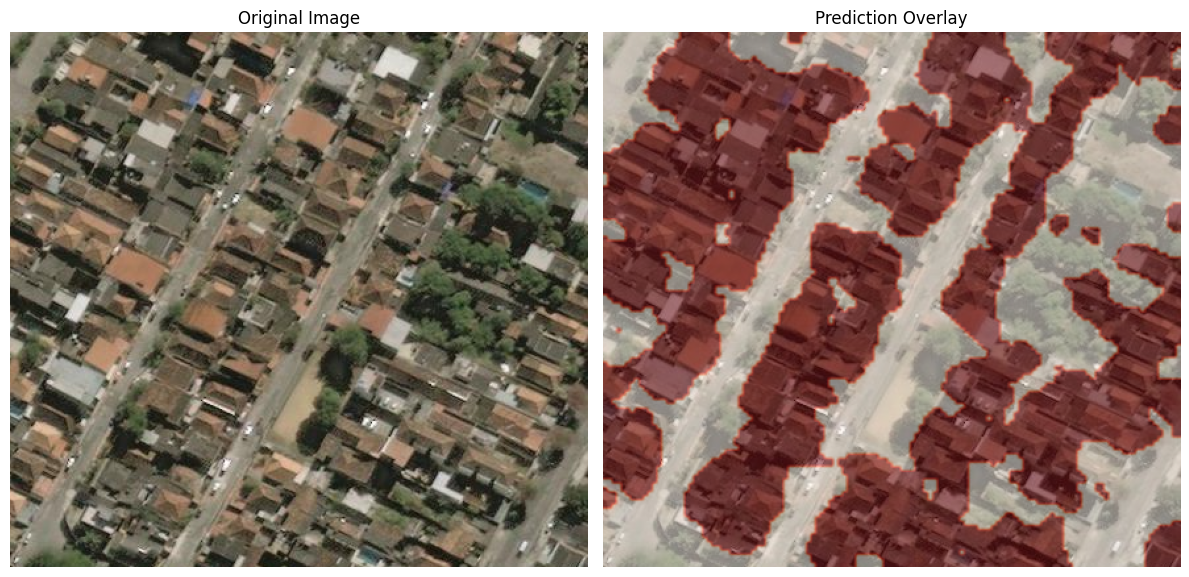

In [141]:
from utils.Utilities import predict
import utils.Visualize as vs

image_path = "/content/datasets/test/3band/3band_AOI_2_RIO_img1067.tif"
prediction = predict(model, image_path, 128, 128)

vs.visualizeOriginalWithMask(image_path, prediction)

# **Ensemble with SAM**

## Create U-Net masks

In [102]:
image_dir = "/content/datasets/test/3band"
unet_mask_dir = "/content/datasets/unet-masks/"
sam_mask_dir = "/content/datasets/sam-masks/"
os.makedirs(sam_mask_dir, exist_ok=True)

In [ ]:
from utils.Utilities import batch_predict_and_save
batch_predict_and_save(model, image_dir, unet_mask_dir, 128, 128)

## Installing SAM and download checkpoint

In [ ]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Create SAM masks

In [97]:
sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
model_type = "vit_h"
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("DEVICE:", DEVICE)

DEVICE: cuda:0


In [98]:
from segment_anything import SamPredictor, sam_model_registry
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(DEVICE)
predictor = SamPredictor(sam)

In [103]:
from preprocess.CreateMaskRasterio import create_sam_masks_from_unet_prediction
create_sam_masks_from_unet_prediction(predictor, image_dir, unet_mask_dir, sam_mask_dir)

SAM Ensemble:   0%|          | 10/2795 [00:04<22:35,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1006


SAM Ensemble:   0%|          | 11/2795 [00:05<21:37,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1007


SAM Ensemble:   0%|          | 12/2795 [00:05<20:58,  2.21it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1008


SAM Ensemble:   1%|          | 31/2795 [00:15<21:47,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1025


SAM Ensemble:   1%|▏         | 36/2795 [00:17<22:42,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img103


SAM Ensemble:   1%|▏         | 41/2795 [00:20<23:31,  1.95it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1034


SAM Ensemble:   2%|▏         | 44/2795 [00:21<22:56,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1037


SAM Ensemble:   2%|▏         | 60/2795 [00:30<21:28,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1051


SAM Ensemble:   2%|▏         | 66/2795 [00:32<21:13,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1057


SAM Ensemble:   3%|▎         | 70/2795 [00:34<21:38,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1060


SAM Ensemble:   3%|▎         | 73/2795 [00:36<22:04,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1063


SAM Ensemble:   3%|▎         | 85/2795 [00:42<22:31,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1074


SAM Ensemble:   3%|▎         | 86/2795 [00:43<21:26,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1075


SAM Ensemble:   3%|▎         | 90/2795 [00:45<22:10,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1079


SAM Ensemble:   3%|▎         | 94/2795 [00:47<22:04,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1082


SAM Ensemble:   4%|▍         | 119/2795 [00:59<21:13,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1104


SAM Ensemble:   4%|▍         | 125/2795 [01:02<22:10,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img111


SAM Ensemble:   5%|▍         | 138/2795 [01:09<22:39,  1.95it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1121


SAM Ensemble:   5%|▌         | 145/2795 [01:13<21:40,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1128


SAM Ensemble:   5%|▌         | 148/2795 [01:14<21:27,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1130


SAM Ensemble:   5%|▌         | 150/2795 [01:15<21:15,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1132


SAM Ensemble:   5%|▌         | 151/2795 [01:16<20:23,  2.16it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1133


SAM Ensemble:   6%|▌         | 156/2795 [01:18<20:43,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1138


SAM Ensemble:   6%|▌         | 160/2795 [01:20<20:00,  2.19it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1141


SAM Ensemble:   6%|▌         | 168/2795 [01:24<21:17,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1149


SAM Ensemble:   7%|▋         | 190/2795 [01:36<20:39,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1169


SAM Ensemble:   7%|▋         | 191/2795 [01:36<19:53,  2.18it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img117


SAM Ensemble:   7%|▋         | 193/2795 [01:37<19:11,  2.26it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1171


SAM Ensemble:   7%|▋         | 207/2795 [01:44<21:15,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1184


SAM Ensemble:   7%|▋         | 209/2795 [01:45<20:56,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1186


SAM Ensemble:   8%|▊         | 213/2795 [01:47<20:46,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img119


SAM Ensemble:   8%|▊         | 223/2795 [01:52<20:43,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1199


SAM Ensemble:   8%|▊         | 231/2795 [01:56<22:36,  1.89it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1205


SAM Ensemble:   8%|▊         | 233/2795 [01:57<20:37,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1207


SAM Ensemble:   9%|▊         | 241/2795 [02:01<20:40,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1214


SAM Ensemble:   9%|▊         | 244/2795 [02:03<20:37,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1217


SAM Ensemble:   9%|▉         | 245/2795 [02:03<19:46,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1218


SAM Ensemble:   9%|▉         | 249/2795 [02:05<20:05,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1221


SAM Ensemble:   9%|▉         | 258/2795 [02:10<20:40,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img123


SAM Ensemble:   9%|▉         | 259/2795 [02:10<19:46,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1230


SAM Ensemble:   9%|▉         | 265/2795 [02:13<19:32,  2.16it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1236


SAM Ensemble:  10%|▉         | 270/2795 [02:16<19:53,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1240


SAM Ensemble:  10%|▉         | 279/2795 [02:20<19:55,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1249


SAM Ensemble:  10%|█         | 281/2795 [02:21<19:46,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1250


SAM Ensemble:  10%|█         | 292/2795 [02:27<21:38,  1.93it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1260


SAM Ensemble:  11%|█         | 296/2795 [02:29<20:32,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1264


SAM Ensemble:  11%|█         | 302/2795 [02:32<20:21,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img127


SAM Ensemble:  11%|█         | 307/2795 [02:35<20:40,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1274


SAM Ensemble:  11%|█         | 310/2795 [02:36<20:26,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1277


SAM Ensemble:  11%|█         | 312/2795 [02:37<20:35,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1279


SAM Ensemble:  11%|█▏        | 315/2795 [02:39<20:39,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1281


SAM Ensemble:  11%|█▏        | 316/2795 [02:39<19:39,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1282


SAM Ensemble:  11%|█▏        | 320/2795 [02:41<19:45,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1286


SAM Ensemble:  12%|█▏        | 324/2795 [02:43<19:30,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img129


SAM Ensemble:  12%|█▏        | 334/2795 [02:48<20:18,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1299


SAM Ensemble:  12%|█▏        | 335/2795 [02:49<19:21,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img13


SAM Ensemble:  12%|█▏        | 343/2795 [02:53<21:26,  1.91it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1306


SAM Ensemble:  12%|█▏        | 344/2795 [02:53<20:08,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1307


SAM Ensemble:  13%|█▎        | 364/2795 [03:04<19:40,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1325


SAM Ensemble:  13%|█▎        | 371/2795 [03:07<19:28,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1331


SAM Ensemble:  14%|█▍        | 402/2795 [03:23<19:02,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img136


SAM Ensemble:  14%|█▍        | 403/2795 [03:23<18:19,  2.18it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1360


SAM Ensemble:  15%|█▍        | 408/2795 [03:26<19:28,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1365


SAM Ensemble:  15%|█▍        | 409/2795 [03:26<18:36,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1366


SAM Ensemble:  15%|█▍        | 411/2795 [03:27<17:55,  2.22it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1368


SAM Ensemble:  15%|█▍        | 417/2795 [03:30<18:47,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1373


SAM Ensemble:  15%|█▍        | 418/2795 [03:30<18:07,  2.19it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1374


SAM Ensemble:  15%|█▌        | 432/2795 [03:37<19:17,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1387


SAM Ensemble:  16%|█▌        | 436/2795 [03:39<18:52,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1390


SAM Ensemble:  16%|█▌        | 443/2795 [03:43<18:33,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1397


SAM Ensemble:  16%|█▌        | 444/2795 [03:43<17:54,  2.19it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1398


SAM Ensemble:  16%|█▌        | 450/2795 [03:47<20:47,  1.88it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1402


SAM Ensemble:  16%|█▌        | 452/2795 [03:48<20:05,  1.94it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1404


SAM Ensemble:  16%|█▋        | 459/2795 [03:51<18:35,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1410


SAM Ensemble:  16%|█▋        | 460/2795 [03:51<17:54,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1411


SAM Ensemble:  17%|█▋        | 464/2795 [03:53<17:53,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1415


SAM Ensemble:  17%|█▋        | 475/2795 [03:59<19:37,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1425


SAM Ensemble:  17%|█▋        | 479/2795 [04:01<19:16,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1429


SAM Ensemble:  17%|█▋        | 486/2795 [04:04<18:28,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1435


SAM Ensemble:  18%|█▊        | 491/2795 [04:07<18:33,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img144


SAM Ensemble:  18%|█▊        | 500/2795 [04:12<19:05,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1448


SAM Ensemble:  18%|█▊        | 507/2795 [04:15<19:07,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1454


SAM Ensemble:  19%|█▊        | 520/2795 [04:22<19:24,  1.95it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1466


SAM Ensemble:  19%|█▊        | 524/2795 [04:24<18:41,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img147


SAM Ensemble:  19%|█▉        | 539/2795 [04:32<18:22,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1483


SAM Ensemble:  19%|█▉        | 544/2795 [04:34<18:20,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1488


SAM Ensemble:  20%|█▉        | 547/2795 [04:36<18:30,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1490


SAM Ensemble:  20%|█▉        | 555/2795 [04:40<16:57,  2.20it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1498


SAM Ensemble:  20%|██        | 566/2795 [04:45<17:08,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1507


SAM Ensemble:  21%|██        | 574/2795 [04:49<18:18,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1514


SAM Ensemble:  21%|██        | 578/2795 [04:51<19:05,  1.93it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1518


SAM Ensemble:  21%|██        | 589/2795 [04:57<17:44,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1528


SAM Ensemble:  21%|██▏       | 594/2795 [04:59<18:13,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1532


SAM Ensemble:  21%|██▏       | 597/2795 [05:01<18:27,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1535


SAM Ensemble:  21%|██▏       | 600/2795 [05:03<18:21,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1538


SAM Ensemble:  22%|██▏       | 601/2795 [05:03<17:25,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1539


SAM Ensemble:  22%|██▏       | 608/2795 [05:07<18:24,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1545


SAM Ensemble:  22%|██▏       | 609/2795 [05:07<17:26,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1546


SAM Ensemble:  22%|██▏       | 617/2795 [05:11<19:30,  1.86it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1553


SAM Ensemble:  22%|██▏       | 620/2795 [05:13<17:59,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1556


SAM Ensemble:  23%|██▎       | 649/2795 [05:28<17:59,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1582


SAM Ensemble:  23%|██▎       | 651/2795 [05:29<17:48,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1584


SAM Ensemble:  23%|██▎       | 653/2795 [05:30<17:38,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1586


SAM Ensemble:  24%|██▎       | 660/2795 [05:34<17:24,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1592


SAM Ensemble:  24%|██▍       | 681/2795 [05:45<17:05,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1610


SAM Ensemble:  25%|██▍       | 691/2795 [05:50<17:14,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img162


SAM Ensemble:  25%|██▌       | 699/2795 [05:54<18:02,  1.94it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1627


SAM Ensemble:  25%|██▌       | 706/2795 [05:58<16:36,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1633


SAM Ensemble:  25%|██▌       | 710/2795 [06:00<16:40,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1637


SAM Ensemble:  26%|██▌       | 716/2795 [06:03<17:21,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1642


SAM Ensemble:  26%|██▌       | 718/2795 [06:04<16:38,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1644


SAM Ensemble:  26%|██▋       | 736/2795 [06:13<17:19,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1660


SAM Ensemble:  26%|██▋       | 737/2795 [06:14<16:25,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1661


SAM Ensemble:  26%|██▋       | 739/2795 [06:15<16:17,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1663


SAM Ensemble:  26%|██▋       | 740/2795 [06:15<15:42,  2.18it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1664


SAM Ensemble:  27%|██▋       | 741/2795 [06:16<15:17,  2.24it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1665


SAM Ensemble:  27%|██▋       | 746/2795 [06:18<16:37,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img167


SAM Ensemble:  27%|██▋       | 747/2795 [06:18<15:54,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1670


SAM Ensemble:  27%|██▋       | 763/2795 [06:27<16:24,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1685


SAM Ensemble:  27%|██▋       | 765/2795 [06:27<16:01,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1687


SAM Ensemble:  28%|██▊       | 771/2795 [06:31<17:27,  1.93it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1692


SAM Ensemble:  28%|██▊       | 774/2795 [06:32<16:16,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1695


SAM Ensemble:  28%|██▊       | 777/2795 [06:33<15:25,  2.18it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1698


SAM Ensemble:  28%|██▊       | 780/2795 [06:35<15:20,  2.19it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img170


SAM Ensemble:  28%|██▊       | 786/2795 [06:38<15:30,  2.16it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1705


SAM Ensemble:  28%|██▊       | 789/2795 [06:39<15:06,  2.21it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1708


SAM Ensemble:  29%|██▊       | 801/2795 [06:45<16:17,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1719


SAM Ensemble:  29%|██▉       | 808/2795 [06:49<16:18,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1725


SAM Ensemble:  29%|██▉       | 813/2795 [06:51<16:21,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img173


SAM Ensemble:  29%|██▉       | 814/2795 [06:52<15:35,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1730


SAM Ensemble:  29%|██▉       | 817/2795 [06:53<15:52,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1733


SAM Ensemble:  29%|██▉       | 819/2795 [06:54<15:23,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1735


SAM Ensemble:  29%|██▉       | 820/2795 [06:55<14:53,  2.21it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1736


SAM Ensemble:  29%|██▉       | 823/2795 [06:56<14:55,  2.20it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1739


SAM Ensemble:  30%|██▉       | 827/2795 [06:58<15:31,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1742


SAM Ensemble:  30%|██▉       | 830/2795 [06:59<15:42,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1745


SAM Ensemble:  30%|██▉       | 834/2795 [07:02<17:04,  1.91it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1749


SAM Ensemble:  31%|███       | 856/2795 [07:14<16:47,  1.92it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1769


SAM Ensemble:  31%|███       | 857/2795 [07:14<15:48,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img177


SAM Ensemble:  31%|███       | 858/2795 [07:14<15:08,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1770


SAM Ensemble:  31%|███       | 860/2795 [07:15<14:58,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1772


SAM Ensemble:  31%|███       | 866/2795 [07:18<15:46,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1778


SAM Ensemble:  31%|███       | 869/2795 [07:20<16:09,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1780


SAM Ensemble:  31%|███▏      | 877/2795 [07:24<16:02,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1788


SAM Ensemble:  31%|███▏      | 879/2795 [07:25<15:33,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img179


SAM Ensemble:  32%|███▏      | 882/2795 [07:26<15:00,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1792


SAM Ensemble:  32%|███▏      | 883/2795 [07:27<14:29,  2.20it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1793


SAM Ensemble:  32%|███▏      | 888/2795 [07:29<15:08,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1798


SAM Ensemble:  32%|███▏      | 899/2795 [07:35<15:15,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1807


SAM Ensemble:  33%|███▎      | 914/2795 [07:43<15:41,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1820


SAM Ensemble:  33%|███▎      | 918/2795 [07:45<15:20,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1824


SAM Ensemble:  33%|███▎      | 921/2795 [07:46<14:53,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1827


SAM Ensemble:  34%|███▎      | 938/2795 [07:55<16:05,  1.92it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1842


SAM Ensemble:  34%|███▎      | 942/2795 [07:57<15:20,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1846


SAM Ensemble:  34%|███▍      | 944/2795 [07:58<14:51,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1848


SAM Ensemble:  34%|███▍      | 945/2795 [07:59<14:15,  2.16it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1849


SAM Ensemble:  34%|███▍      | 946/2795 [07:59<13:50,  2.23it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img185


SAM Ensemble:  34%|███▍      | 957/2795 [08:05<15:03,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img186


SAM Ensemble:  34%|███▍      | 960/2795 [08:06<14:54,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1862


SAM Ensemble:  34%|███▍      | 963/2795 [08:08<14:13,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1865


SAM Ensemble:  34%|███▍      | 964/2795 [08:08<13:46,  2.21it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1866


SAM Ensemble:  35%|███▍      | 965/2795 [08:09<13:28,  2.26it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1867


SAM Ensemble:  35%|███▍      | 967/2795 [08:10<14:01,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1869


SAM Ensemble:  35%|███▌      | 981/2795 [08:17<15:40,  1.93it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1881


SAM Ensemble:  35%|███▌      | 984/2795 [08:19<14:49,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1884


SAM Ensemble:  35%|███▌      | 987/2795 [08:20<14:46,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1887


SAM Ensemble:  35%|███▌      | 991/2795 [08:22<14:32,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1890


SAM Ensemble:  36%|███▌      | 995/2795 [08:24<14:36,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1894


SAM Ensemble:  36%|███▌      | 996/2795 [08:25<13:58,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1895


SAM Ensemble:  36%|███▌      | 1005/2795 [08:29<14:20,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1902


SAM Ensemble:  36%|███▋      | 1016/2795 [08:35<14:17,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1912


SAM Ensemble:  37%|███▋      | 1023/2795 [08:38<14:25,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1919


SAM Ensemble:  37%|███▋      | 1025/2795 [08:39<14:12,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1920


SAM Ensemble:  37%|███▋      | 1031/2795 [08:42<14:27,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1926


SAM Ensemble:  37%|███▋      | 1033/2795 [08:43<14:02,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1928


SAM Ensemble:  37%|███▋      | 1035/2795 [08:44<13:40,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img193


SAM Ensemble:  37%|███▋      | 1040/2795 [08:47<14:08,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1934


SAM Ensemble:  37%|███▋      | 1043/2795 [08:48<14:12,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1937


SAM Ensemble:  38%|███▊      | 1050/2795 [08:52<14:21,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1943


SAM Ensemble:  38%|███▊      | 1055/2795 [08:54<13:58,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1948


SAM Ensemble:  38%|███▊      | 1058/2795 [08:56<13:35,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1950


SAM Ensemble:  38%|███▊      | 1060/2795 [08:57<13:34,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1952


SAM Ensemble:  38%|███▊      | 1063/2795 [08:58<13:43,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1955


SAM Ensemble:  38%|███▊      | 1071/2795 [09:02<13:46,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1962


SAM Ensemble:  39%|███▊      | 1081/2795 [09:07<13:44,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1971


SAM Ensemble:  39%|███▉      | 1085/2795 [09:09<13:44,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1975


SAM Ensemble:  39%|███▉      | 1088/2795 [09:11<13:56,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1978


SAM Ensemble:  39%|███▉      | 1092/2795 [09:13<13:31,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1981


SAM Ensemble:  39%|███▉      | 1104/2795 [09:19<13:53,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1992


SAM Ensemble:  40%|███▉      | 1108/2795 [09:21<13:40,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1996


SAM Ensemble:  40%|███▉      | 1109/2795 [09:21<13:05,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1997


SAM Ensemble:  40%|███▉      | 1111/2795 [09:22<12:45,  2.20it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1999


SAM Ensemble:  40%|███▉      | 1116/2795 [09:25<13:20,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2001


SAM Ensemble:  40%|████      | 1119/2795 [09:26<12:40,  2.20it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2004


SAM Ensemble:  40%|████      | 1121/2795 [09:27<12:39,  2.20it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2006


SAM Ensemble:  40%|████      | 1129/2795 [09:31<13:05,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2013


SAM Ensemble:  41%|████      | 1141/2795 [09:37<13:08,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2024


SAM Ensemble:  41%|████      | 1145/2795 [09:39<13:31,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2028


SAM Ensemble:  41%|████      | 1152/2795 [09:42<13:48,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2034


SAM Ensemble:  41%|████▏     | 1158/2795 [09:45<13:10,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img204


SAM Ensemble:  42%|████▏     | 1168/2795 [09:50<13:17,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2049


SAM Ensemble:  42%|████▏     | 1175/2795 [09:54<13:30,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2055


SAM Ensemble:  42%|████▏     | 1181/2795 [09:57<13:32,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2060


SAM Ensemble:  42%|████▏     | 1184/2795 [09:59<13:29,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2063


SAM Ensemble:  43%|████▎     | 1206/2795 [10:10<13:31,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2083


SAM Ensemble:  43%|████▎     | 1215/2795 [10:15<13:04,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2091


SAM Ensemble:  44%|████▎     | 1216/2795 [10:15<12:27,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2092


SAM Ensemble:  44%|████▎     | 1217/2795 [10:16<12:00,  2.19it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2093


SAM Ensemble:  44%|████▎     | 1218/2795 [10:16<11:41,  2.25it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2094


SAM Ensemble:  44%|████▎     | 1219/2795 [10:16<11:28,  2.29it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2095


SAM Ensemble:  44%|████▍     | 1228/2795 [10:21<13:12,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2102


SAM Ensemble:  44%|████▍     | 1231/2795 [10:23<13:09,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2105


SAM Ensemble:  44%|████▍     | 1240/2795 [10:28<13:13,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2113


SAM Ensemble:  45%|████▍     | 1245/2795 [10:30<12:41,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2118


SAM Ensemble:  45%|████▍     | 1246/2795 [10:30<12:07,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2119


SAM Ensemble:  45%|████▍     | 1254/2795 [10:35<12:44,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2126


SAM Ensemble:  45%|████▍     | 1256/2795 [10:36<12:19,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2128


SAM Ensemble:  45%|████▌     | 1259/2795 [10:37<12:28,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2130


SAM Ensemble:  45%|████▌     | 1260/2795 [10:37<11:56,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2131


SAM Ensemble:  45%|████▌     | 1264/2795 [10:39<12:01,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2135


SAM Ensemble:  45%|████▌     | 1267/2795 [10:41<12:10,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2138


SAM Ensemble:  46%|████▌     | 1274/2795 [10:44<11:53,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2144


SAM Ensemble:  46%|████▌     | 1276/2795 [10:45<11:53,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2146


SAM Ensemble:  46%|████▌     | 1282/2795 [10:48<12:28,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2151


SAM Ensemble:  46%|████▌     | 1285/2795 [10:50<11:40,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2154


SAM Ensemble:  46%|████▌     | 1287/2795 [10:51<11:57,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2156


SAM Ensemble:  47%|████▋     | 1308/2795 [11:02<12:07,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2175


SAM Ensemble:  47%|████▋     | 1309/2795 [11:02<11:35,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2176


SAM Ensemble:  47%|████▋     | 1315/2795 [11:05<12:14,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2181


SAM Ensemble:  47%|████▋     | 1317/2795 [11:06<11:40,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2183


SAM Ensemble:  47%|████▋     | 1319/2795 [11:07<11:20,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2185


SAM Ensemble:  48%|████▊     | 1329/2795 [11:12<11:53,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2194


SAM Ensemble:  48%|████▊     | 1333/2795 [11:14<11:36,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2198


SAM Ensemble:  48%|████▊     | 1336/2795 [11:16<11:34,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img220


SAM Ensemble:  48%|████▊     | 1339/2795 [11:17<11:45,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2202


SAM Ensemble:  48%|████▊     | 1345/2795 [11:20<11:24,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2208


SAM Ensemble:  48%|████▊     | 1346/2795 [11:20<11:02,  2.19it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2209


SAM Ensemble:  48%|████▊     | 1348/2795 [11:21<10:48,  2.23it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2210


SAM Ensemble:  48%|████▊     | 1355/2795 [11:25<11:51,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2217


SAM Ensemble:  49%|████▊     | 1356/2795 [11:25<11:19,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2218


SAM Ensemble:  49%|████▊     | 1360/2795 [11:27<11:34,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2221


SAM Ensemble:  49%|████▉     | 1364/2795 [11:29<11:21,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2225


SAM Ensemble:  49%|████▉     | 1372/2795 [11:33<11:59,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2232


SAM Ensemble:  49%|████▉     | 1378/2795 [11:36<11:18,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2238


SAM Ensemble:  49%|████▉     | 1383/2795 [11:39<11:59,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2242


SAM Ensemble:  50%|████▉     | 1387/2795 [11:41<11:05,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2246


SAM Ensemble:  50%|████▉     | 1392/2795 [11:43<11:11,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2250


SAM Ensemble:  50%|█████     | 1408/2795 [11:52<11:04,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2265


SAM Ensemble:  50%|█████     | 1410/2795 [11:53<11:18,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2267


SAM Ensemble:  51%|█████     | 1430/2795 [12:03<11:12,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2285


SAM Ensemble:  51%|█████▏    | 1435/2795 [12:06<11:01,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img229


SAM Ensemble:  51%|█████▏    | 1439/2795 [12:08<10:40,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2293


SAM Ensemble:  52%|█████▏    | 1444/2795 [12:10<10:40,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2298


SAM Ensemble:  52%|█████▏    | 1446/2795 [12:11<10:11,  2.21it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img23


SAM Ensemble:  52%|█████▏    | 1455/2795 [12:15<10:24,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2307


SAM Ensemble:  52%|█████▏    | 1463/2795 [12:19<10:11,  2.18it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2314


SAM Ensemble:  53%|█████▎    | 1481/2795 [12:28<10:41,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2330


SAM Ensemble:  53%|█████▎    | 1482/2795 [12:29<10:13,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2331


SAM Ensemble:  53%|█████▎    | 1495/2795 [12:36<10:37,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2343


SAM Ensemble:  54%|█████▎    | 1501/2795 [12:39<11:03,  1.95it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2349


SAM Ensemble:  54%|█████▍    | 1505/2795 [12:41<10:53,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2352


SAM Ensemble:  54%|█████▍    | 1507/2795 [12:42<10:42,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2354


SAM Ensemble:  54%|█████▍    | 1513/2795 [12:45<10:44,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img236


SAM Ensemble:  54%|█████▍    | 1516/2795 [12:47<10:23,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2362


SAM Ensemble:  55%|█████▍    | 1526/2795 [12:52<10:04,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2371


SAM Ensemble:  55%|█████▍    | 1531/2795 [12:54<09:47,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2376


SAM Ensemble:  55%|█████▍    | 1537/2795 [12:57<09:57,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2381


SAM Ensemble:  55%|█████▌    | 1539/2795 [12:58<09:41,  2.16it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2383


SAM Ensemble:  55%|█████▌    | 1541/2795 [12:59<09:36,  2.18it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2385


SAM Ensemble:  55%|█████▌    | 1545/2795 [13:01<09:54,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2389


SAM Ensemble:  55%|█████▌    | 1547/2795 [13:02<09:27,  2.20it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2390


SAM Ensemble:  56%|█████▌    | 1567/2795 [13:12<10:30,  1.95it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2408


SAM Ensemble:  56%|█████▋    | 1574/2795 [13:16<10:12,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2414


SAM Ensemble:  57%|█████▋    | 1590/2795 [13:24<09:34,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2429


SAM Ensemble:  57%|█████▋    | 1595/2795 [13:27<09:24,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2433


SAM Ensemble:  58%|█████▊    | 1608/2795 [13:33<10:09,  1.95it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2445


SAM Ensemble:  58%|█████▊    | 1631/2795 [13:45<09:35,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2466


SAM Ensemble:  58%|█████▊    | 1634/2795 [13:47<09:22,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2469


SAM Ensemble:  59%|█████▊    | 1638/2795 [13:49<09:24,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2472


SAM Ensemble:  59%|█████▉    | 1652/2795 [13:56<09:24,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2485


SAM Ensemble:  59%|█████▉    | 1658/2795 [13:59<09:11,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2490


SAM Ensemble:  59%|█████▉    | 1661/2795 [14:01<09:07,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2493


SAM Ensemble:  59%|█████▉    | 1663/2795 [14:02<08:47,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2495


SAM Ensemble:  60%|██████    | 1688/2795 [14:15<09:32,  1.93it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2517


SAM Ensemble:  61%|██████    | 1693/2795 [14:18<08:51,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2521


SAM Ensemble:  61%|██████    | 1697/2795 [14:20<08:46,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2525


SAM Ensemble:  61%|██████    | 1704/2795 [14:23<08:55,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2531


SAM Ensemble:  61%|██████▏   | 1716/2795 [14:29<08:32,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2542


SAM Ensemble:  61%|██████▏   | 1717/2795 [14:30<08:13,  2.18it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2543


SAM Ensemble:  62%|██████▏   | 1720/2795 [14:31<08:22,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2546


SAM Ensemble:  62%|██████▏   | 1723/2795 [14:33<08:13,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2549


SAM Ensemble:  62%|██████▏   | 1725/2795 [14:34<08:11,  2.18it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2550


SAM Ensemble:  62%|██████▏   | 1731/2795 [14:37<08:40,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2556


SAM Ensemble:  63%|██████▎   | 1747/2795 [14:44<08:01,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2570


SAM Ensemble:  63%|██████▎   | 1748/2795 [14:45<07:48,  2.24it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2571


SAM Ensemble:  63%|██████▎   | 1758/2795 [14:50<08:18,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2580


SAM Ensemble:  63%|██████▎   | 1770/2795 [14:56<08:19,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2591


SAM Ensemble:  63%|██████▎   | 1773/2795 [14:57<08:07,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2594


SAM Ensemble:  64%|██████▍   | 1789/2795 [15:05<08:02,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2608


SAM Ensemble:  64%|██████▍   | 1792/2795 [15:07<07:46,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2610


SAM Ensemble:  65%|██████▍   | 1803/2795 [15:12<08:22,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2620


SAM Ensemble:  65%|██████▍   | 1810/2795 [15:16<08:06,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2627


SAM Ensemble:  65%|██████▍   | 1811/2795 [15:16<07:43,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2628


SAM Ensemble:  65%|██████▌   | 1819/2795 [15:20<07:45,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2635


SAM Ensemble:  65%|██████▌   | 1822/2795 [15:22<07:38,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2638


SAM Ensemble:  65%|██████▌   | 1828/2795 [15:25<07:44,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2643


SAM Ensemble:  66%|██████▌   | 1833/2795 [15:28<08:08,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2648


SAM Ensemble:  66%|██████▌   | 1842/2795 [15:32<08:20,  1.90it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2656


SAM Ensemble:  66%|██████▌   | 1844/2795 [15:33<07:53,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2658


SAM Ensemble:  66%|██████▌   | 1847/2795 [15:35<07:29,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2660


SAM Ensemble:  66%|██████▌   | 1850/2795 [15:36<07:17,  2.16it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2663


SAM Ensemble:  67%|██████▋   | 1866/2795 [15:44<07:39,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2678


SAM Ensemble:  67%|██████▋   | 1867/2795 [15:45<07:17,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2679


SAM Ensemble:  67%|██████▋   | 1882/2795 [15:53<07:50,  1.94it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2692


SAM Ensemble:  68%|██████▊   | 1894/2795 [15:59<07:24,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2702


SAM Ensemble:  69%|██████▊   | 1916/2795 [16:10<07:17,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2722


SAM Ensemble:  69%|██████▉   | 1925/2795 [16:15<07:11,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2730


SAM Ensemble:  69%|██████▉   | 1933/2795 [16:19<07:07,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2738


SAM Ensemble:  69%|██████▉   | 1940/2795 [16:22<06:58,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2744


SAM Ensemble:  70%|██████▉   | 1951/2795 [16:28<07:13,  1.95it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2754


SAM Ensemble:  70%|██████▉   | 1953/2795 [16:29<06:51,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2756


SAM Ensemble:  70%|██████▉   | 1954/2795 [16:29<06:33,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2757


SAM Ensemble:  70%|███████   | 1957/2795 [16:31<06:25,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img276


SAM Ensemble:  70%|███████   | 1961/2795 [16:33<06:53,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2763


SAM Ensemble:  70%|███████   | 1967/2795 [16:36<06:50,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2769


SAM Ensemble:  70%|███████   | 1969/2795 [16:37<06:42,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2770


SAM Ensemble:  71%|███████   | 1971/2795 [16:38<06:28,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2772


SAM Ensemble:  71%|███████   | 1972/2795 [16:38<06:14,  2.20it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2773


SAM Ensemble:  71%|███████   | 1974/2795 [16:39<06:23,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2775


SAM Ensemble:  71%|███████▏  | 1996/2795 [16:50<06:07,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2795


SAM Ensemble:  72%|███████▏  | 2003/2795 [16:54<06:43,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img285


SAM Ensemble:  72%|███████▏  | 2014/2795 [17:00<06:17,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img295


SAM Ensemble:  72%|███████▏  | 2024/2795 [17:05<06:31,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img303


SAM Ensemble:  73%|███████▎  | 2027/2795 [17:07<06:13,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img306


SAM Ensemble:  73%|███████▎  | 2028/2795 [17:07<05:57,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img307


SAM Ensemble:  73%|███████▎  | 2033/2795 [17:10<06:20,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img311


SAM Ensemble:  73%|███████▎  | 2046/2795 [17:16<06:16,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img323


SAM Ensemble:  73%|███████▎  | 2050/2795 [17:18<06:16,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img327


SAM Ensemble:  73%|███████▎  | 2054/2795 [17:20<05:54,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img330


SAM Ensemble:  74%|███████▎  | 2055/2795 [17:21<05:40,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img331


SAM Ensemble:  74%|███████▎  | 2057/2795 [17:22<05:48,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img333


SAM Ensemble:  74%|███████▍  | 2066/2795 [17:27<06:15,  1.94it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img341


SAM Ensemble:  74%|███████▍  | 2070/2795 [17:29<05:45,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img345


SAM Ensemble:  74%|███████▍  | 2072/2795 [17:29<05:32,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img347


SAM Ensemble:  74%|███████▍  | 2077/2795 [17:32<05:36,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img351


SAM Ensemble:  74%|███████▍  | 2078/2795 [17:32<05:25,  2.20it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img352


SAM Ensemble:  74%|███████▍  | 2082/2795 [17:34<05:53,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img356


SAM Ensemble:  75%|███████▍  | 2095/2795 [17:41<05:45,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img368


SAM Ensemble:  75%|███████▌  | 2103/2795 [17:45<05:20,  2.16it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img375


SAM Ensemble:  75%|███████▌  | 2108/2795 [17:48<05:35,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img38


SAM Ensemble:  76%|███████▌  | 2115/2795 [17:51<05:44,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img386


SAM Ensemble:  76%|███████▌  | 2117/2795 [17:52<05:31,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img388


SAM Ensemble:  76%|███████▌  | 2121/2795 [17:54<05:25,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img391


SAM Ensemble:  76%|███████▌  | 2126/2795 [17:57<05:15,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img396


SAM Ensemble:  77%|███████▋  | 2143/2795 [18:06<05:29,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img410


SAM Ensemble:  77%|███████▋  | 2153/2795 [18:11<05:16,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img42


SAM Ensemble:  77%|███████▋  | 2156/2795 [18:12<05:21,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img422


SAM Ensemble:  77%|███████▋  | 2160/2795 [18:14<05:03,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img426


SAM Ensemble:  77%|███████▋  | 2166/2795 [18:17<05:19,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img431


SAM Ensemble:  78%|███████▊  | 2173/2795 [18:21<05:05,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img438


SAM Ensemble:  78%|███████▊  | 2177/2795 [18:23<05:16,  1.95it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img441


SAM Ensemble:  78%|███████▊  | 2181/2795 [18:25<04:57,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img445


SAM Ensemble:  78%|███████▊  | 2183/2795 [18:26<04:41,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img447


SAM Ensemble:  78%|███████▊  | 2191/2795 [18:30<04:43,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img454


SAM Ensemble:  79%|███████▉  | 2211/2795 [18:40<04:35,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img472


SAM Ensemble:  80%|███████▉  | 2226/2795 [18:48<04:43,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img486


SAM Ensemble:  80%|███████▉  | 2231/2795 [18:51<04:36,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img490


SAM Ensemble:  80%|███████▉  | 2232/2795 [18:51<04:23,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img491


SAM Ensemble:  80%|████████  | 2238/2795 [18:55<04:48,  1.93it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img497


SAM Ensemble:  80%|████████  | 2239/2795 [18:55<04:31,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img498


SAM Ensemble:  80%|████████  | 2248/2795 [19:00<04:28,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img505


SAM Ensemble:  81%|████████  | 2251/2795 [19:01<04:19,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img508


SAM Ensemble:  81%|████████  | 2266/2795 [19:09<04:29,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img521


SAM Ensemble:  82%|████████▏ | 2278/2795 [19:15<04:23,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img532


SAM Ensemble:  82%|████████▏ | 2280/2795 [19:16<04:06,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img534


SAM Ensemble:  82%|████████▏ | 2285/2795 [19:19<04:09,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img539


SAM Ensemble:  82%|████████▏ | 2286/2795 [19:19<03:58,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img54


SAM Ensemble:  82%|████████▏ | 2293/2795 [19:23<04:04,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img546


SAM Ensemble:  82%|████████▏ | 2297/2795 [19:25<04:12,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img55


SAM Ensemble:  83%|████████▎ | 2312/2795 [19:33<03:51,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img563


SAM Ensemble:  83%|████████▎ | 2315/2795 [19:34<03:52,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img566


SAM Ensemble:  83%|████████▎ | 2321/2795 [19:37<03:58,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img571


SAM Ensemble:  83%|████████▎ | 2323/2795 [19:38<03:52,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img573


SAM Ensemble:  83%|████████▎ | 2328/2795 [19:41<03:54,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img578


SAM Ensemble:  83%|████████▎ | 2332/2795 [19:43<03:45,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img581


SAM Ensemble:  84%|████████▎ | 2335/2795 [19:45<03:56,  1.95it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img584


SAM Ensemble:  84%|████████▎ | 2338/2795 [19:46<03:55,  1.94it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img587


SAM Ensemble:  84%|████████▎ | 2339/2795 [19:47<03:41,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img588


SAM Ensemble:  84%|████████▍ | 2348/2795 [19:51<03:30,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img596


SAM Ensemble:  85%|████████▍ | 2366/2795 [20:00<03:28,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img611


SAM Ensemble:  85%|████████▍ | 2371/2795 [20:03<03:17,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img616


SAM Ensemble:  85%|████████▌ | 2386/2795 [20:11<03:32,  1.92it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img63


SAM Ensemble:  85%|████████▌ | 2389/2795 [20:12<03:24,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img632


SAM Ensemble:  86%|████████▌ | 2394/2795 [20:15<03:07,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img637


SAM Ensemble:  86%|████████▌ | 2395/2795 [20:15<03:01,  2.21it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img638


SAM Ensemble:  86%|████████▌ | 2400/2795 [20:18<03:11,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img642


SAM Ensemble:  86%|████████▌ | 2401/2795 [20:18<03:03,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img643


SAM Ensemble:  86%|████████▋ | 2416/2795 [20:26<03:06,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img657


SAM Ensemble:  87%|████████▋ | 2418/2795 [20:27<02:56,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img659


SAM Ensemble:  87%|████████▋ | 2425/2795 [20:30<02:54,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img665


SAM Ensemble:  87%|████████▋ | 2431/2795 [20:33<03:01,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img670


SAM Ensemble:  87%|████████▋ | 2435/2795 [20:35<02:54,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img674


SAM Ensemble:  87%|████████▋ | 2438/2795 [20:37<02:44,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img677


SAM Ensemble:  87%|████████▋ | 2441/2795 [20:38<02:44,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img68


SAM Ensemble:  88%|████████▊ | 2446/2795 [20:40<02:48,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img684


SAM Ensemble:  88%|████████▊ | 2455/2795 [20:45<02:52,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img692


SAM Ensemble:  88%|████████▊ | 2461/2795 [20:48<02:45,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img698


SAM Ensemble:  88%|████████▊ | 2465/2795 [20:50<02:44,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img700


SAM Ensemble:  89%|████████▊ | 2477/2795 [20:57<02:44,  1.93it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img711


SAM Ensemble:  89%|████████▉ | 2500/2795 [21:08<02:21,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img732


SAM Ensemble:  90%|████████▉ | 2502/2795 [21:09<02:15,  2.16it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img734


SAM Ensemble:  90%|████████▉ | 2507/2795 [21:12<02:15,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img739


SAM Ensemble:  90%|████████▉ | 2508/2795 [21:12<02:10,  2.19it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img74


SAM Ensemble:  90%|████████▉ | 2513/2795 [21:15<02:18,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img744


SAM Ensemble:  90%|█████████ | 2517/2795 [21:17<02:09,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img748


SAM Ensemble:  90%|█████████ | 2522/2795 [21:19<02:12,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img752


SAM Ensemble:  90%|█████████ | 2523/2795 [21:20<02:06,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img753


SAM Ensemble:  91%|█████████ | 2538/2795 [21:27<02:06,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img767


SAM Ensemble:  91%|█████████ | 2548/2795 [21:33<02:05,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img776


SAM Ensemble:  91%|█████████ | 2550/2795 [21:34<01:56,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img778


SAM Ensemble:  91%|█████████▏| 2555/2795 [21:36<01:51,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img782


SAM Ensemble:  92%|█████████▏| 2566/2795 [21:41<01:52,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img792


SAM Ensemble:  92%|█████████▏| 2567/2795 [21:42<01:47,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img793


SAM Ensemble:  92%|█████████▏| 2568/2795 [21:42<01:43,  2.20it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img794


SAM Ensemble:  92%|█████████▏| 2571/2795 [21:44<01:48,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img797


SAM Ensemble:  92%|█████████▏| 2579/2795 [21:48<01:50,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img803


SAM Ensemble:  92%|█████████▏| 2580/2795 [21:48<01:43,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img804


SAM Ensemble:  92%|█████████▏| 2581/2795 [21:49<01:39,  2.16it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img805


SAM Ensemble:  92%|█████████▏| 2582/2795 [21:49<01:35,  2.22it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img806


SAM Ensemble:  93%|█████████▎| 2590/2795 [21:53<01:37,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img813


SAM Ensemble:  93%|█████████▎| 2591/2795 [21:54<01:33,  2.18it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img814


SAM Ensemble:  93%|█████████▎| 2599/2795 [21:58<01:39,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img821


SAM Ensemble:  93%|█████████▎| 2600/2795 [21:58<01:33,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img822


SAM Ensemble:  94%|█████████▎| 2618/2795 [22:08<01:28,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img839


SAM Ensemble:  94%|█████████▎| 2619/2795 [22:08<01:23,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img84


SAM Ensemble:  94%|█████████▍| 2622/2795 [22:10<01:20,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img842


SAM Ensemble:  94%|█████████▍| 2634/2795 [22:16<01:17,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img853


SAM Ensemble:  94%|█████████▍| 2635/2795 [22:16<01:14,  2.16it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img854


SAM Ensemble:  94%|█████████▍| 2636/2795 [22:17<01:11,  2.22it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img855


SAM Ensemble:  95%|█████████▍| 2642/2795 [22:20<01:15,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img860


SAM Ensemble:  95%|█████████▍| 2643/2795 [22:20<01:11,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img861


SAM Ensemble:  95%|█████████▍| 2647/2795 [22:22<01:13,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img865


SAM Ensemble:  95%|█████████▌| 2656/2795 [22:27<01:06,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img873


SAM Ensemble:  95%|█████████▌| 2660/2795 [22:29<01:05,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img877


SAM Ensemble:  95%|█████████▌| 2665/2795 [22:31<01:05,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img881


SAM Ensemble:  96%|█████████▌| 2671/2795 [22:35<01:03,  1.95it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img887


SAM Ensemble:  96%|█████████▌| 2676/2795 [22:37<00:58,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img891


SAM Ensemble:  96%|█████████▌| 2677/2795 [22:38<00:55,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img892


SAM Ensemble:  96%|█████████▌| 2678/2795 [22:38<00:53,  2.21it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img893


SAM Ensemble:  96%|█████████▋| 2691/2795 [22:45<00:54,  1.93it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img904


SAM Ensemble:  96%|█████████▋| 2694/2795 [22:47<00:50,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img907


SAM Ensemble:  97%|█████████▋| 2705/2795 [22:52<00:44,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img917


SAM Ensemble:  97%|█████████▋| 2707/2795 [22:53<00:42,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img919


SAM Ensemble:  97%|█████████▋| 2708/2795 [22:54<00:40,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img92


SAM Ensemble:  97%|█████████▋| 2711/2795 [22:55<00:42,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img922


SAM Ensemble:  97%|█████████▋| 2714/2795 [22:57<00:38,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img925


SAM Ensemble:  97%|█████████▋| 2717/2795 [22:58<00:37,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img928


SAM Ensemble:  97%|█████████▋| 2722/2795 [23:01<00:35,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img932


SAM Ensemble:  98%|█████████▊| 2736/2795 [23:08<00:29,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img945


SAM Ensemble:  98%|█████████▊| 2738/2795 [23:09<00:26,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img947


SAM Ensemble:  98%|█████████▊| 2745/2795 [23:13<00:22,  2.18it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img953


SAM Ensemble:  98%|█████████▊| 2746/2795 [23:13<00:21,  2.24it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img954


SAM Ensemble:  99%|█████████▊| 2758/2795 [23:20<00:18,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img965


SAM Ensemble:  99%|█████████▉| 2763/2795 [23:22<00:15,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img97


SAM Ensemble:  99%|█████████▉| 2766/2795 [23:24<00:14,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img972


SAM Ensemble:  99%|█████████▉| 2775/2795 [23:28<00:09,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img980


SAM Ensemble:  99%|█████████▉| 2776/2795 [23:29<00:09,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img981


SAM Ensemble:  99%|█████████▉| 2779/2795 [23:30<00:07,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img984


SAM Ensemble: 100%|██████████| 2795/2795 [23:38<00:00,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img999


### Download SAM and U-Net masks (For backup and resuse)

In [19]:
import shutil
import zipfile

def zip_folder(folder_path, output_zip_path):
    """Zips the contents of a folder into a zip file.

    Args:
        folder_path: The path to the folder to be zipped.
        output_zip_path: The path to the output zip file.
    """

    with zipfile.ZipFile(output_zip_path, "w") as zip_file:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zip_file.write(file_path)

In [122]:
# unet_zip_path = "/content/datasets/unet-masks.zip"
sam_zip_path = "/content/datasets/sam-masks.zip"

# zip_folder(unet_mask_dir, unet_zip_path)
zip_folder(unet_mask_dir, sam_zip_path)

In [123]:
from google.colab import files
# files.download(unet_zip_path)
files.download(sam_zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Fusion U-Net and SAM masks

### Install PyDenseCRF

In [104]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-mmj3fa5w
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-mmj3fa5w
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 76, in resolve
    collected = self.factory.collect_root_requirements(root_reqs)
                ^^^^^^^^^^^^^^^^

### Fusion using Union, Weighted, Conditional Random Field (CRF) strategies

In [120]:
from ensemble.fusion import batch_fusion
fused_mask_dir = "/content/datasets/fused-masks"
batch_fusion(image_dir, unet_mask_dir, sam_mask_dir, fused_mask_dir)

Fusion masks:   0%|          | 2/2795 [00:00<14:58,  3.11it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2756


Fusion masks:   0%|          | 6/2795 [00:01<12:40,  3.67it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1739


Fusion masks:   1%|          | 24/2795 [00:06<13:27,  3.43it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1249


Fusion masks:   1%|▏         | 39/2795 [00:10<13:23,  3.43it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img587


Fusion masks:   1%|▏         | 41/2795 [00:11<10:19,  4.45it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2627
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2376


Fusion masks:   2%|▏         | 51/2795 [00:13<12:39,  3.61it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2146


Fusion masks:   2%|▏         | 63/2795 [00:16<13:15,  3.43it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2571
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img119
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1498


Fusion masks:   3%|▎         | 70/2795 [00:17<09:49,  4.63it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img632


Fusion masks:   3%|▎         | 74/2795 [00:18<10:19,  4.39it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2769
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1920


Fusion masks:   4%|▎         | 103/2795 [00:27<14:03,  3.19it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2414
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2383
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1221
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img356


Fusion masks:   4%|▍         | 110/2795 [00:27<08:57,  4.99it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1415


Fusion masks:   4%|▍         | 113/2795 [00:28<09:00,  4.96it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img431


Fusion masks:   4%|▍         | 115/2795 [00:28<08:18,  5.38it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2658
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img822


Fusion masks:   4%|▍         | 119/2795 [00:29<07:49,  5.70it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2060


Fusion masks:   4%|▍         | 124/2795 [00:30<10:32,  4.23it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1281


Fusion masks:   5%|▍         | 129/2795 [00:31<10:21,  4.29it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img739


Fusion masks:   5%|▍         | 135/2795 [00:33<12:29,  3.55it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img74
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2225


Fusion masks:   5%|▌         | 148/2795 [00:36<13:47,  3.20it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img945


Fusion masks:   5%|▌         | 152/2795 [00:37<12:11,  3.61it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2648


Fusion masks:   6%|▌         | 163/2795 [00:40<13:16,  3.31it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1034


Fusion masks:   6%|▌         | 167/2795 [00:41<10:59,  3.99it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img984


Fusion masks:   7%|▋         | 183/2795 [00:46<14:16,  3.05it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2628


Fusion masks:   7%|▋         | 190/2795 [00:48<14:20,  3.03it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2610


Fusion masks:   7%|▋         | 195/2795 [00:49<12:33,  3.45it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1792


Fusion masks:   7%|▋         | 201/2795 [00:51<13:06,  3.30it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img236


Fusion masks:   7%|▋         | 206/2795 [00:52<11:42,  3.69it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2531


Fusion masks:   8%|▊         | 215/2795 [00:55<13:32,  3.17it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img782


Fusion masks:   8%|▊         | 224/2795 [00:57<13:09,  3.26it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1934
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1627
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1325


Fusion masks:   8%|▊         | 231/2795 [00:58<10:26,  4.09it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1869


Fusion masks:   8%|▊         | 235/2795 [00:59<10:39,  4.00it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1660
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2352


Fusion masks:   9%|▊         | 241/2795 [01:01<10:45,  3.96it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img368


Fusion masks:   9%|▊         | 243/2795 [01:01<09:30,  4.48it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1435


Fusion masks:   9%|▉         | 246/2795 [01:01<08:42,  4.88it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2620


Fusion masks:   9%|▉         | 250/2795 [01:02<09:48,  4.32it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img571


Fusion masks:   9%|▉         | 263/2795 [01:06<13:26,  3.14it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img805


Fusion masks:  10%|▉         | 271/2795 [01:08<12:19,  3.42it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img891


Fusion masks:  10%|█         | 286/2795 [01:12<10:57,  3.82it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img454


Fusion masks:  10%|█         | 290/2795 [01:13<10:33,  3.95it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img873


Fusion masks:  11%|█         | 294/2795 [01:14<09:44,  4.28it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2525
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1141


Fusion masks:  11%|█         | 297/2795 [01:14<06:49,  6.09it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2185
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img692


Fusion masks:  11%|█         | 311/2795 [01:18<12:03,  3.43it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img445


Fusion masks:  11%|█▏        | 320/2795 [01:20<10:42,  3.85it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1307


Fusion masks:  12%|█▏        | 325/2795 [01:21<10:34,  3.89it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img505


Fusion masks:  12%|█▏        | 331/2795 [01:23<11:40,  3.52it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2151
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2209


Fusion masks:  12%|█▏        | 340/2795 [01:25<09:53,  4.14it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1865


Fusion masks:  12%|█▏        | 342/2795 [01:25<07:45,  5.27it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1788


Fusion masks:  12%|█▏        | 346/2795 [01:26<09:46,  4.17it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1518


Fusion masks:  13%|█▎        | 355/2795 [01:28<08:14,  4.94it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2194


Fusion masks:  13%|█▎        | 357/2795 [01:29<09:53,  4.10it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img331
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1943


Fusion masks:  13%|█▎        | 370/2795 [01:32<10:56,  3.69it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img532
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1398


Fusion masks:  14%|█▎        | 380/2795 [01:35<10:38,  3.78it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img521


Fusion masks:  14%|█▍        | 386/2795 [01:36<11:40,  3.44it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2349


Fusion masks:  14%|█▍        | 391/2795 [01:38<11:09,  3.59it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img472


Fusion masks:  14%|█▍        | 395/2795 [01:38<10:49,  3.70it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2389


Fusion masks:  15%|█▍        | 407/2795 [01:42<11:50,  3.36it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img186


Fusion masks:  15%|█▍        | 412/2795 [01:43<10:44,  3.70it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1528


Fusion masks:  15%|█▌        | 423/2795 [01:46<11:26,  3.45it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img813
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2521


Fusion masks:  16%|█▌        | 444/2795 [01:52<10:48,  3.62it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2570


Fusion masks:  16%|█▌        | 449/2795 [01:53<09:52,  3.96it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img351


Fusion masks:  16%|█▌        | 453/2795 [01:54<10:17,  3.79it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1025


Fusion masks:  16%|█▋        | 461/2795 [01:55<07:30,  5.18it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2390


Fusion masks:  17%|█▋        | 473/2795 [01:59<10:56,  3.54it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img907


Fusion masks:  17%|█▋        | 480/2795 [02:01<11:39,  3.31it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2638


Fusion masks:  17%|█▋        | 486/2795 [02:02<10:53,  3.53it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img642


Fusion masks:  18%|█▊        | 490/2795 [02:03<09:41,  3.97it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1981
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1798


Fusion masks:  18%|█▊        | 494/2795 [02:04<07:45,  4.94it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img814
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2635


Fusion masks:  18%|█▊        | 501/2795 [02:05<09:12,  4.15it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1079


Fusion masks:  18%|█▊        | 504/2795 [02:06<08:50,  4.32it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1063


Fusion masks:  18%|█▊        | 511/2795 [02:08<09:41,  3.92it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1996
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img732


Fusion masks:  19%|█▊        | 522/2795 [02:10<10:45,  3.52it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img792


Fusion masks:  19%|█▉        | 527/2795 [02:12<11:29,  3.29it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1742


Fusion masks:  19%|█▉        | 536/2795 [02:14<10:25,  3.61it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img803


Fusion masks:  19%|█▉        | 540/2795 [02:15<09:25,  3.99it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2094


Fusion masks:  20%|█▉        | 546/2795 [02:17<10:43,  3.49it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img491


Fusion masks:  20%|█▉        | 554/2795 [02:19<09:31,  3.92it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img928


Fusion masks:  20%|█▉        | 557/2795 [02:19<07:54,  4.72it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2126


Fusion masks:  20%|██        | 572/2795 [02:24<10:24,  3.56it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2218


Fusion masks:  21%|██        | 590/2795 [02:29<11:30,  3.19it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img311


Fusion masks:  21%|██        | 593/2795 [02:29<08:54,  4.12it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img999


Fusion masks:  21%|██▏       | 596/2795 [02:30<08:01,  4.56it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img776
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2678


Fusion masks:  22%|██▏       | 603/2795 [02:31<08:55,  4.10it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1121
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1948
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1538


Fusion masks:  22%|██▏       | 617/2795 [02:34<08:06,  4.48it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1488


Fusion masks:  22%|██▏       | 621/2795 [02:35<08:25,  4.30it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1133


Fusion masks:  23%|██▎       | 629/2795 [02:37<09:53,  3.65it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img861
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img806
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2643


Fusion masks:  23%|██▎       | 634/2795 [02:37<06:14,  5.77it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img391


Fusion masks:  23%|██▎       | 644/2795 [02:40<10:02,  3.57it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img173


Fusion masks:  23%|██▎       | 648/2795 [02:41<09:15,  3.87it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2775


Fusion masks:  23%|██▎       | 653/2795 [02:42<09:08,  3.90it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1586


Fusion masks:  24%|██▎       | 657/2795 [02:43<08:45,  4.07it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1171


Fusion masks:  24%|██▍       | 675/2795 [02:48<09:43,  3.63it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1429


Fusion masks:  24%|██▍       | 682/2795 [02:50<09:07,  3.86it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2092


Fusion masks:  25%|██▍       | 696/2795 [02:54<10:35,  3.30it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2130


Fusion masks:  25%|██▍       | 698/2795 [02:54<08:12,  4.25it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1824


Fusion masks:  25%|██▌       | 702/2795 [02:55<08:26,  4.13it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1277


Fusion masks:  25%|██▌       | 709/2795 [02:57<09:37,  3.61it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img534


Fusion masks:  26%|██▌       | 713/2795 [02:58<08:58,  3.87it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1545


Fusion masks:  26%|██▌       | 720/2795 [02:59<09:29,  3.65it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1365


Fusion masks:  27%|██▋       | 759/2795 [03:11<09:13,  3.68it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1733
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1887


Fusion masks:  27%|██▋       | 767/2795 [03:12<10:11,  3.32it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1075


Fusion masks:  28%|██▊       | 793/2795 [03:20<10:10,  3.28it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1890


Fusion masks:  29%|██▊       | 798/2795 [03:21<09:21,  3.56it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1687


Fusion masks:  29%|██▊       | 801/2795 [03:22<08:53,  3.74it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2113


Fusion masks:  29%|██▉       | 808/2795 [03:24<08:52,  3.73it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2144


Fusion masks:  29%|██▉       | 814/2795 [03:25<10:05,  3.27it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1705
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1008


Fusion masks:  29%|██▉       | 818/2795 [03:26<07:09,  4.60it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1698


Fusion masks:  29%|██▉       | 821/2795 [03:26<06:24,  5.13it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img700
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img422


Fusion masks:  30%|██▉       | 835/2795 [03:30<09:44,  3.35it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1592


Fusion masks:  30%|███       | 841/2795 [03:32<08:12,  3.97it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1633


Fusion masks:  30%|███       | 852/2795 [03:34<08:45,  3.70it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img323


Fusion masks:  31%|███       | 854/2795 [03:35<07:01,  4.60it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1708


Fusion masks:  31%|███       | 860/2795 [03:36<08:50,  3.65it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2083


Fusion masks:  31%|███▏      | 874/2795 [03:40<09:18,  3.44it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1670


Fusion masks:  31%|███▏      | 877/2795 [03:41<08:19,  3.84it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2429


Fusion masks:  32%|███▏      | 900/2795 [03:47<06:01,  5.24it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1912


Fusion masks:  32%|███▏      | 902/2795 [03:47<06:56,  4.54it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img185


Fusion masks:  32%|███▏      | 904/2795 [03:48<05:51,  5.39it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img54


Fusion masks:  33%|███▎      | 914/2795 [03:50<07:23,  4.24it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2663


Fusion masks:  33%|███▎      | 923/2795 [03:52<08:26,  3.70it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img616


Fusion masks:  33%|███▎      | 925/2795 [03:53<06:30,  4.79it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1848


Fusion masks:  33%|███▎      | 929/2795 [03:54<07:07,  4.36it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1664


Fusion masks:  34%|███▍      | 960/2795 [04:02<06:07,  4.99it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1661


Fusion masks:  34%|███▍      | 961/2795 [04:02<07:30,  4.07it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2445


Fusion masks:  35%|███▍      | 965/2795 [04:03<07:18,  4.17it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1390
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2371


Fusion masks:  35%|███▌      | 979/2795 [04:07<09:16,  3.26it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1104


Fusion masks:  35%|███▌      | 989/2795 [04:09<08:23,  3.58it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img498


Fusion masks:  36%|███▌      | 996/2795 [04:11<08:11,  3.66it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img333


Fusion masks:  36%|███▌      | 1003/2795 [04:13<09:28,  3.15it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1051
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img111
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1006


Fusion masks:  36%|███▌      | 1009/2795 [04:14<04:20,  6.85it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1556


Fusion masks:  37%|███▋      | 1024/2795 [04:18<07:54,  3.73it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img447


Fusion masks:  37%|███▋      | 1028/2795 [04:19<07:01,  4.20it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img63


Fusion masks:  37%|███▋      | 1032/2795 [04:20<07:22,  3.99it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2738


Fusion masks:  37%|███▋      | 1034/2795 [04:20<06:10,  4.75it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2293


Fusion masks:  38%|███▊      | 1050/2795 [04:24<08:23,  3.46it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img947


Fusion masks:  38%|███▊      | 1052/2795 [04:25<06:39,  4.36it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img486


Fusion masks:  38%|███▊      | 1065/2795 [04:28<08:49,  3.27it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2385


Fusion masks:  38%|███▊      | 1067/2795 [04:29<06:53,  4.18it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img13


Fusion masks:  38%|███▊      | 1074/2795 [04:30<07:59,  3.59it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1950
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img573


Fusion masks:  39%|███▊      | 1082/2795 [04:32<08:21,  3.41it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img347
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img539


Fusion masks:  39%|███▉      | 1091/2795 [04:34<07:04,  4.01it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img853


Fusion masks:  39%|███▉      | 1104/2795 [04:37<04:38,  6.06it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img97
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img84


Fusion masks:  40%|███▉      | 1108/2795 [04:38<07:06,  3.96it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img767
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1780
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2433


Fusion masks:  40%|████      | 1126/2795 [04:43<08:01,  3.47it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img388


Fusion masks:  41%|████      | 1133/2795 [04:44<07:22,  3.76it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img177


Fusion masks:  41%|████      | 1136/2795 [04:45<06:16,  4.40it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img804


Fusion masks:  41%|████      | 1141/2795 [04:46<07:27,  3.70it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2183


Fusion masks:  41%|████▏     | 1153/2795 [04:50<08:39,  3.16it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2795


Fusion masks:  41%|████▏     | 1159/2795 [04:51<08:09,  3.34it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img893


Fusion masks:  42%|████▏     | 1163/2795 [04:52<07:42,  3.53it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1207


Fusion masks:  42%|████▏     | 1171/2795 [04:55<07:51,  3.44it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1955


Fusion masks:  42%|████▏     | 1173/2795 [04:55<06:19,  4.27it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img677


Fusion masks:  42%|████▏     | 1176/2795 [04:56<06:10,  4.37it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1642


Fusion masks:  42%|████▏     | 1181/2795 [04:57<07:25,  3.62it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img441
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1360


Fusion masks:  43%|████▎     | 1189/2795 [04:59<07:26,  3.60it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2265


Fusion masks:  43%|████▎     | 1194/2795 [05:00<07:20,  3.64it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1214
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1881


Fusion masks:  43%|████▎     | 1200/2795 [05:01<06:25,  4.14it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img123


Fusion masks:  43%|████▎     | 1204/2795 [05:02<06:07,  4.33it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img698


Fusion masks:  43%|████▎     | 1208/2795 [05:03<06:28,  4.09it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1584


Fusion masks:  44%|████▎     | 1216/2795 [05:05<07:02,  3.74it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img860
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img23


Fusion masks:  44%|████▍     | 1223/2795 [05:06<06:40,  3.93it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2128
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2594


Fusion masks:  44%|████▍     | 1228/2795 [05:07<05:44,  4.55it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1719


Fusion masks:  44%|████▍     | 1237/2795 [05:10<07:17,  3.56it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1230


Fusion masks:  44%|████▍     | 1239/2795 [05:10<05:49,  4.46it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2095


Fusion masks:  45%|████▍     | 1251/2795 [05:13<08:06,  3.17it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2343


Fusion masks:  45%|████▍     | 1257/2795 [05:15<07:48,  3.29it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1971


Fusion masks:  45%|████▌     | 1264/2795 [05:17<07:47,  3.28it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2004
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1770


Fusion masks:  46%|████▌     | 1272/2795 [05:19<06:50,  3.71it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img980


Fusion masks:  46%|████▌     | 1277/2795 [05:20<06:37,  3.82it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2049
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2208


Fusion masks:  46%|████▌     | 1291/2795 [05:23<07:27,  3.36it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img386


Fusion masks:  46%|████▋     | 1296/2795 [05:25<07:29,  3.33it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img752
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img566
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1778
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1306


Fusion masks:  47%|████▋     | 1314/2795 [05:29<07:36,  3.25it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1962


Fusion masks:  47%|████▋     | 1316/2795 [05:29<05:51,  4.21it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img965
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img972


Fusion masks:  47%|████▋     | 1322/2795 [05:31<05:43,  4.29it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img778
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1374


Fusion masks:  48%|████▊     | 1332/2795 [05:33<06:48,  3.58it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img734


Fusion masks:  48%|████▊     | 1336/2795 [05:34<05:57,  4.08it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1387


Fusion masks:  48%|████▊     | 1338/2795 [05:34<05:05,  4.77it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2135


Fusion masks:  48%|████▊     | 1345/2795 [05:36<06:19,  3.82it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2242


Fusion masks:  48%|████▊     | 1355/2795 [05:39<06:54,  3.47it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2472


Fusion masks:  49%|████▉     | 1366/2795 [05:42<07:42,  3.09it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1060


Fusion masks:  49%|████▉     | 1368/2795 [05:42<05:37,  4.22it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1978


Fusion masks:  49%|████▉     | 1375/2795 [05:44<06:34,  3.60it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2314


Fusion masks:  49%|████▉     | 1378/2795 [05:44<05:45,  4.10it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1928


Fusion masks:  49%|████▉     | 1382/2795 [05:45<05:40,  4.15it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img42


Fusion masks:  50%|████▉     | 1384/2795 [05:46<04:52,  4.83it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1286


Fusion masks:  50%|████▉     | 1396/2795 [05:49<07:32,  3.09it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2770


Fusion masks:  50%|█████     | 1398/2795 [05:49<05:41,  4.09it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2154


Fusion masks:  50%|█████     | 1409/2795 [05:52<06:40,  3.46it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1884


Fusion masks:  50%|█████     | 1411/2795 [05:53<05:07,  4.50it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img954
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img611


Fusion masks:  51%|█████     | 1431/2795 [05:58<06:50,  3.32it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2331
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img295


Fusion masks:  51%|█████▏    | 1434/2795 [05:59<04:46,  4.75it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2542


Fusion masks:  51%|█████▏    | 1436/2795 [05:59<04:18,  5.26it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img684


Fusion masks:  51%|█████▏    | 1438/2795 [05:59<03:58,  5.70it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img546


Fusion masks:  52%|█████▏    | 1443/2795 [06:00<05:23,  4.18it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img341
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1692
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img144


Fusion masks:  53%|█████▎    | 1468/2795 [06:06<04:23,  5.03it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1695
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2466
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2660


Fusion masks:  53%|█████▎    | 1481/2795 [06:10<06:30,  3.37it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2198


Fusion masks:  53%|█████▎    | 1485/2795 [06:10<05:12,  4.20it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2772
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img748


Fusion masks:  53%|█████▎    | 1491/2795 [06:12<05:05,  4.27it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1264


Fusion masks:  53%|█████▎    | 1495/2795 [06:13<05:05,  4.25it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1205


Fusion masks:  54%|█████▎    | 1497/2795 [06:13<04:08,  5.23it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1037


Fusion masks:  54%|█████▍    | 1517/2795 [06:18<06:14,  3.41it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img794


Fusion masks:  54%|█████▍    | 1520/2795 [06:19<05:00,  4.24it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2298
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img865


Fusion masks:  54%|█████▍    | 1523/2795 [06:19<03:34,  5.93it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img162


Fusion masks:  55%|█████▍    | 1526/2795 [06:20<03:47,  5.58it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img330


Fusion masks:  55%|█████▌    | 1548/2795 [06:26<05:53,  3.53it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1937


Fusion masks:  56%|█████▌    | 1555/2795 [06:28<05:17,  3.90it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img127


Fusion masks:  56%|█████▌    | 1561/2795 [06:29<05:12,  3.95it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1250


Fusion masks:  56%|█████▌    | 1566/2795 [06:30<05:57,  3.44it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1736
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1685
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1199


Fusion masks:  56%|█████▌    | 1572/2795 [06:31<04:20,  4.70it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1582
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img584


Fusion masks:  57%|█████▋    | 1582/2795 [06:34<06:01,  3.36it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1402


Fusion masks:  57%|█████▋    | 1585/2795 [06:34<04:20,  4.65it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1397


Fusion masks:  57%|█████▋    | 1588/2795 [06:35<04:05,  4.92it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1807


Fusion masks:  57%|█████▋    | 1605/2795 [06:39<05:23,  3.67it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1926


Fusion masks:  58%|█████▊    | 1610/2795 [06:40<04:42,  4.19it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1745


Fusion masks:  58%|█████▊    | 1617/2795 [06:42<04:43,  4.16it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img887


Fusion masks:  58%|█████▊    | 1630/2795 [06:45<05:55,  3.27it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img276


Fusion masks:  59%|█████▊    | 1640/2795 [06:48<05:06,  3.77it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1299
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1866


Fusion masks:  59%|█████▉    | 1656/2795 [06:52<05:26,  3.49it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2246
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1448


Fusion masks:  59%|█████▉    | 1660/2795 [06:53<04:05,  4.62it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img204


Fusion masks:  59%|█████▉    | 1662/2795 [06:54<03:53,  4.85it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1454


Fusion masks:  60%|█████▉    | 1674/2795 [06:57<05:16,  3.54it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2102


Fusion masks:  60%|██████    | 1686/2795 [07:00<05:09,  3.58it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1218


Fusion masks:  61%|██████    | 1691/2795 [07:01<05:06,  3.60it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img327


Fusion masks:  61%|██████    | 1693/2795 [07:02<04:01,  4.55it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1827


Fusion masks:  61%|██████    | 1698/2795 [07:03<04:17,  4.27it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2105


Fusion masks:  61%|██████    | 1702/2795 [07:04<04:33,  4.00it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2493


Fusion masks:  61%|██████    | 1711/2795 [07:06<05:40,  3.19it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img306


Fusion masks:  62%|██████▏   | 1723/2795 [07:10<05:55,  3.02it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img410


Fusion masks:  62%|██████▏   | 1732/2795 [07:12<05:08,  3.44it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img68


Fusion masks:  62%|██████▏   | 1737/2795 [07:13<04:25,  3.98it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2591


Fusion masks:  62%|██████▏   | 1744/2795 [07:15<05:18,  3.30it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2469


Fusion masks:  63%|██████▎   | 1753/2795 [07:17<03:27,  5.03it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img877


Fusion masks:  63%|██████▎   | 1754/2795 [07:18<04:00,  4.33it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1849


Fusion masks:  63%|██████▎   | 1756/2795 [07:18<03:30,  4.94it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img904


Fusion masks:  63%|██████▎   | 1760/2795 [07:19<03:46,  4.57it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2549


Fusion masks:  63%|██████▎   | 1766/2795 [07:20<04:58,  3.45it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img855


Fusion masks:  63%|██████▎   | 1774/2795 [07:23<04:57,  3.43it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2131


Fusion masks:  64%|██████▎   | 1779/2795 [07:24<04:55,  3.44it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img953


Fusion masks:  64%|██████▎   | 1781/2795 [07:24<04:12,  4.02it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2238


Fusion masks:  64%|██████▍   | 1793/2795 [07:27<04:34,  3.65it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img892


Fusion masks:  64%|██████▍   | 1800/2795 [07:29<05:16,  3.14it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2556


Fusion masks:  65%|██████▌   | 1821/2795 [07:35<04:24,  3.68it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2091


Fusion masks:  65%|██████▌   | 1824/2795 [07:36<04:05,  3.96it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1274


Fusion masks:  65%|██████▌   | 1826/2795 [07:36<03:28,  4.66it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2679


Fusion masks:  66%|██████▌   | 1838/2795 [07:39<04:24,  3.61it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1514


Fusion masks:  66%|██████▌   | 1848/2795 [07:42<04:23,  3.59it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1919


Fusion masks:  66%|██████▌   | 1851/2795 [07:43<03:38,  4.33it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2034


Fusion masks:  67%|██████▋   | 1861/2795 [07:45<04:45,  3.27it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img147


Fusion masks:  67%|██████▋   | 1868/2795 [07:47<04:28,  3.45it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1130


Fusion masks:  67%|██████▋   | 1877/2795 [07:50<04:32,  3.37it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img744
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1902


Fusion masks:  68%|██████▊   | 1892/2795 [07:54<04:39,  3.23it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1793


Fusion masks:  68%|██████▊   | 1897/2795 [07:55<04:25,  3.38it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1867


Fusion masks:  68%|██████▊   | 1899/2795 [07:55<03:36,  4.13it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2024


Fusion masks:  68%|██████▊   | 1905/2795 [07:57<03:47,  3.92it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2692


Fusion masks:  69%|██████▊   | 1916/2795 [08:00<04:33,  3.21it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1282
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1368


Fusion masks:  69%|██████▊   | 1919/2795 [08:00<03:04,  4.76it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img179


Fusion masks:  69%|██████▉   | 1927/2795 [08:02<04:01,  3.59it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1186


Fusion masks:  69%|██████▉   | 1934/2795 [08:04<04:13,  3.39it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1975


Fusion masks:  69%|██████▉   | 1939/2795 [08:05<04:03,  3.52it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1735


Fusion masks:  69%|██████▉   | 1941/2795 [08:06<03:11,  4.47it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1532


Fusion masks:  70%|██████▉   | 1949/2795 [08:08<04:22,  3.23it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2773


Fusion masks:  70%|██████▉   | 1953/2795 [08:09<03:48,  3.68it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2202


Fusion masks:  70%|███████   | 1959/2795 [08:11<04:14,  3.28it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2550


Fusion masks:  70%|███████   | 1967/2795 [08:13<04:01,  3.43it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img345


Fusion masks:  71%|███████   | 1978/2795 [08:16<04:09,  3.28it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1184


Fusion masks:  71%|███████   | 1980/2795 [08:16<03:14,  4.18it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img797


Fusion masks:  71%|███████   | 1986/2795 [08:17<03:49,  3.52it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1410
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2055


Fusion masks:  71%|███████▏  | 1997/2795 [08:20<03:59,  3.33it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img303


Fusion masks:  72%|███████▏  | 2008/2795 [08:23<03:16,  4.01it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1169


Fusion masks:  72%|███████▏  | 2018/2795 [08:25<03:47,  3.42it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2543


Fusion masks:  72%|███████▏  | 2021/2795 [08:26<03:22,  3.81it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1842


Fusion masks:  72%|███████▏  | 2025/2795 [08:26<02:05,  6.11it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img490


Fusion masks:  73%|███████▎  | 2028/2795 [08:27<03:03,  4.18it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2138


Fusion masks:  73%|███████▎  | 2030/2795 [08:28<02:46,  4.59it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1425


Fusion masks:  73%|███████▎  | 2047/2795 [08:33<04:12,  2.96it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img426


Fusion masks:  74%|███████▎  | 2057/2795 [08:36<03:51,  3.19it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2517
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1952


Fusion masks:  74%|███████▎  | 2061/2795 [08:36<02:44,  4.46it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img793
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1846


Fusion masks:  74%|███████▍  | 2070/2795 [08:38<03:22,  3.57it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1999


Fusion masks:  74%|███████▍  | 2077/2795 [08:40<02:52,  4.16it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2730


Fusion masks:  75%|███████▍  | 2084/2795 [08:42<03:18,  3.58it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img842


Fusion masks:  75%|███████▌  | 2097/2795 [08:45<01:59,  5.83it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2485
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img919


Fusion masks:  76%|███████▌  | 2117/2795 [08:50<03:17,  3.43it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img285
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img659
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2063


Fusion masks:  76%|███████▌  | 2123/2795 [08:51<02:32,  4.40it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1730


Fusion masks:  76%|███████▌  | 2131/2795 [08:53<03:03,  3.63it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img38
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img563


Fusion masks:  76%|███████▋  | 2136/2795 [08:54<02:09,  5.08it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1553


Fusion masks:  77%|███████▋  | 2140/2795 [08:55<02:39,  4.12it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1466


Fusion masks:  77%|███████▋  | 2142/2795 [08:55<02:17,  4.73it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1074


Fusion masks:  77%|███████▋  | 2166/2795 [09:02<03:12,  3.26it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2381
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img229
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1366


Fusion masks:  78%|███████▊  | 2175/2795 [09:04<02:41,  3.84it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1637


Fusion masks:  78%|███████▊  | 2189/2795 [09:08<03:09,  3.20it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img167


Fusion masks:  78%|███████▊  | 2192/2795 [09:09<02:22,  4.24it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img352


Fusion masks:  79%|███████▊  | 2197/2795 [09:10<02:37,  3.81it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2608


Fusion masks:  79%|███████▉  | 2202/2795 [09:11<02:26,  4.05it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2580


Fusion masks:  79%|███████▉  | 2208/2795 [09:13<02:46,  3.52it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img581


Fusion masks:  79%|███████▉  | 2219/2795 [09:16<02:59,  3.22it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1404


Fusion masks:  79%|███████▉  | 2221/2795 [09:16<02:18,  4.13it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2156


Fusion masks:  80%|███████▉  | 2234/2795 [09:20<02:49,  3.31it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img497
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2001
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2093


Fusion masks:  80%|████████  | 2245/2795 [09:22<02:46,  3.29it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1610


Fusion masks:  80%|████████  | 2249/2795 [09:23<02:28,  3.68it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2702
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1483


Fusion masks:  81%|████████▏ | 2274/2795 [09:30<02:17,  3.78it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img711


Fusion masks:  82%|████████▏ | 2278/2795 [09:31<01:55,  4.47it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2232


Fusion masks:  82%|████████▏ | 2285/2795 [09:32<02:17,  3.70it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2546


Fusion masks:  82%|████████▏ | 2291/2795 [09:34<02:10,  3.87it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1260


Fusion masks:  82%|████████▏ | 2295/2795 [09:35<02:02,  4.08it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img665
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1279


Fusion masks:  82%|████████▏ | 2300/2795 [09:36<01:45,  4.71it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img917
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1007


Fusion masks:  82%|████████▏ | 2303/2795 [09:36<01:16,  6.45it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img193


Fusion masks:  83%|████████▎ | 2323/2795 [09:41<02:01,  3.90it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1997
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2028


Fusion masks:  83%|████████▎ | 2326/2795 [09:42<01:18,  5.97it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1217


Fusion masks:  83%|████████▎ | 2329/2795 [09:42<01:21,  5.75it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img657


Fusion masks:  83%|████████▎ | 2332/2795 [09:43<01:33,  4.95it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img136


Fusion masks:  84%|████████▎ | 2335/2795 [09:43<01:22,  5.55it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2330


Fusion masks:  84%|████████▍ | 2343/2795 [09:45<02:06,  3.58it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2744
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1772
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2656


Fusion masks:  84%|████████▍ | 2354/2795 [09:48<02:09,  3.40it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img508
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img925
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img307


Fusion masks:  84%|████████▍ | 2359/2795 [09:48<01:14,  5.82it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2408


Fusion masks:  85%|████████▍ | 2363/2795 [09:49<01:40,  4.30it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1138


Fusion masks:  85%|████████▍ | 2372/2795 [09:52<01:59,  3.54it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img375
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img103
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img396


Fusion masks:  85%|████████▌ | 2378/2795 [09:53<01:26,  4.85it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2757
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1507


Fusion masks:  85%|████████▌ | 2384/2795 [09:54<01:35,  4.32it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img821
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img981


Fusion masks:  86%|████████▌ | 2391/2795 [09:55<01:37,  4.15it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1411


Fusion masks:  86%|████████▌ | 2394/2795 [09:56<01:22,  4.85it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img578
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1373


Fusion masks:  86%|████████▌ | 2397/2795 [09:56<00:58,  6.75it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2490


Fusion masks:  86%|████████▌ | 2401/2795 [09:57<01:20,  4.90it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1535


Fusion masks:  86%|████████▌ | 2406/2795 [09:58<01:50,  3.53it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2354


Fusion masks:  86%|████████▋ | 2415/2795 [10:01<01:54,  3.31it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1820


Fusion masks:  87%|████████▋ | 2440/2795 [10:08<01:33,  3.80it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1894
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img220


Fusion masks:  87%|████████▋ | 2444/2795 [10:08<01:05,  5.37it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img638


Fusion masks:  88%|████████▊ | 2460/2795 [10:13<01:37,  3.44it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2118


Fusion masks:  88%|████████▊ | 2464/2795 [10:14<01:39,  3.33it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1539


Fusion masks:  88%|████████▊ | 2468/2795 [10:15<01:27,  3.74it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2307


Fusion masks:  88%|████████▊ | 2472/2795 [10:16<01:16,  4.23it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2722


Fusion masks:  89%|████████▊ | 2474/2795 [10:16<01:03,  5.03it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1057


Fusion masks:  89%|████████▊ | 2476/2795 [10:16<00:54,  5.81it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img881


Fusion masks:  89%|████████▉ | 2492/2795 [10:21<01:27,  3.48it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2763


Fusion masks:  90%|████████▉ | 2509/2795 [10:25<01:29,  3.20it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img129


Fusion masks:  90%|████████▉ | 2512/2795 [10:26<01:12,  3.89it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1663


Fusion masks:  90%|████████▉ | 2515/2795 [10:27<01:06,  4.19it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img674


Fusion masks:  90%|█████████ | 2526/2795 [10:30<01:19,  3.36it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1644
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img170


Fusion masks:  90%|█████████ | 2529/2795 [10:30<00:50,  5.27it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1862
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2754


Fusion masks:  91%|█████████ | 2532/2795 [10:30<00:36,  7.18it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2210


Fusion masks:  91%|█████████ | 2536/2795 [10:31<00:50,  5.17it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2495


Fusion masks:  91%|█████████ | 2541/2795 [10:32<01:01,  4.13it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1992


Fusion masks:  91%|█████████ | 2546/2795 [10:34<01:06,  3.76it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img117


Fusion masks:  91%|█████████▏| 2551/2795 [10:35<01:04,  3.79it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1149


Fusion masks:  91%|█████████▏| 2554/2795 [10:35<00:56,  4.30it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img753


Fusion masks:  91%|█████████▏| 2557/2795 [10:36<00:51,  4.66it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img438


Fusion masks:  92%|█████████▏| 2569/2795 [10:39<00:55,  4.09it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1331


Fusion masks:  93%|█████████▎| 2586/2795 [10:44<01:00,  3.44it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1132


Fusion masks:  93%|█████████▎| 2590/2795 [10:45<00:48,  4.20it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img922
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img670


Fusion masks:  93%|█████████▎| 2593/2795 [10:45<00:33,  6.05it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img637


Fusion masks:  93%|█████████▎| 2600/2795 [10:47<00:42,  4.57it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2119


Fusion masks:  93%|█████████▎| 2607/2795 [10:48<00:34,  5.48it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img839


Fusion masks:  93%|█████████▎| 2608/2795 [10:48<00:39,  4.76it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1128
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1082


Fusion masks:  94%|█████████▍| 2628/2795 [10:53<00:47,  3.55it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img588


Fusion masks:  94%|█████████▍| 2636/2795 [10:56<00:47,  3.35it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1240


Fusion masks:  95%|█████████▍| 2645/2795 [10:58<00:49,  3.01it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1546


Fusion masks:  95%|█████████▍| 2648/2795 [10:59<00:42,  3.42it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2285


Fusion masks:  95%|█████████▍| 2654/2795 [11:01<00:41,  3.39it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1725


Fusion masks:  95%|█████████▌| 2665/2795 [11:03<00:36,  3.54it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1236


Fusion masks:  95%|█████████▌| 2669/2795 [11:04<00:35,  3.50it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1490


Fusion masks:  96%|█████████▌| 2675/2795 [11:06<00:30,  3.91it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2175


Fusion masks:  96%|█████████▌| 2680/2795 [11:07<00:28,  4.01it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1895


Fusion masks:  96%|█████████▌| 2687/2795 [11:08<00:21,  5.13it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img643


Fusion masks:  96%|█████████▋| 2693/2795 [11:10<00:25,  3.99it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1665
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img55
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img854


Fusion masks:  97%|█████████▋| 2710/2795 [11:14<00:25,  3.38it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2217


Fusion masks:  97%|█████████▋| 2712/2795 [11:14<00:19,  4.34it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2006


Fusion masks:  98%|█████████▊| 2732/2795 [11:20<00:20,  3.10it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1769


Fusion masks:  98%|█████████▊| 2747/2795 [11:25<00:13,  3.45it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img932


Fusion masks:  98%|█████████▊| 2752/2795 [11:26<00:10,  4.00it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2181


Fusion masks:  99%|█████████▊| 2754/2795 [11:26<00:08,  4.59it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2250


Fusion masks:  99%|█████████▊| 2759/2795 [11:27<00:08,  4.33it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img92


Fusion masks:  99%|█████████▉| 2763/2795 [11:28<00:08,  3.94it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img596


Fusion masks:  99%|█████████▉| 2773/2795 [11:31<00:06,  3.50it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2013


Fusion masks:  99%|█████████▉| 2779/2795 [11:32<00:04,  3.96it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2267


Fusion masks: 100%|█████████▉| 2783/2795 [11:33<00:02,  4.16it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2362


Fusion masks: 100%|█████████▉| 2791/2795 [11:35<00:01,  3.67it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2176
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2221


Fusion masks: 100%|██████████| 2795/2795 [11:36<00:00,  4.02it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1749


In [121]:
fused_zip_path = "/content/datasets/fused-masks.zip"
zip_folder(fused_mask_dir, fused_zip_path)
files.download(fused_zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Visualize all masks

In [124]:
base_name = "3band_AOI_2_RIO_img1067"

In [129]:
import importlib
import utils.Visualize
importlib.reload(utils.Visualize)

<module 'utils.Visualize' from '/content/utils/Visualize.py'>

In [134]:
import cv2
from utils.Visualize import visualize_with_multiple_masks

# Ensure image load as grayscale and numerical (0 or 1)
image_path = f"/content/datasets/test/3band/{base_name}.tif"
unet_mask = cv2.imread(f"/content/datasets/unet-masks/{base_name}.png", cv2.IMREAD_GRAYSCALE)
sam_mask = cv2.imread(f"/content/datasets/sam-masks/{base_name}.png", cv2.IMREAD_GRAYSCALE)

mask1 = (unet_mask, "U-Net Mask")
mask2 = (sam_mask, "SAM Mask")

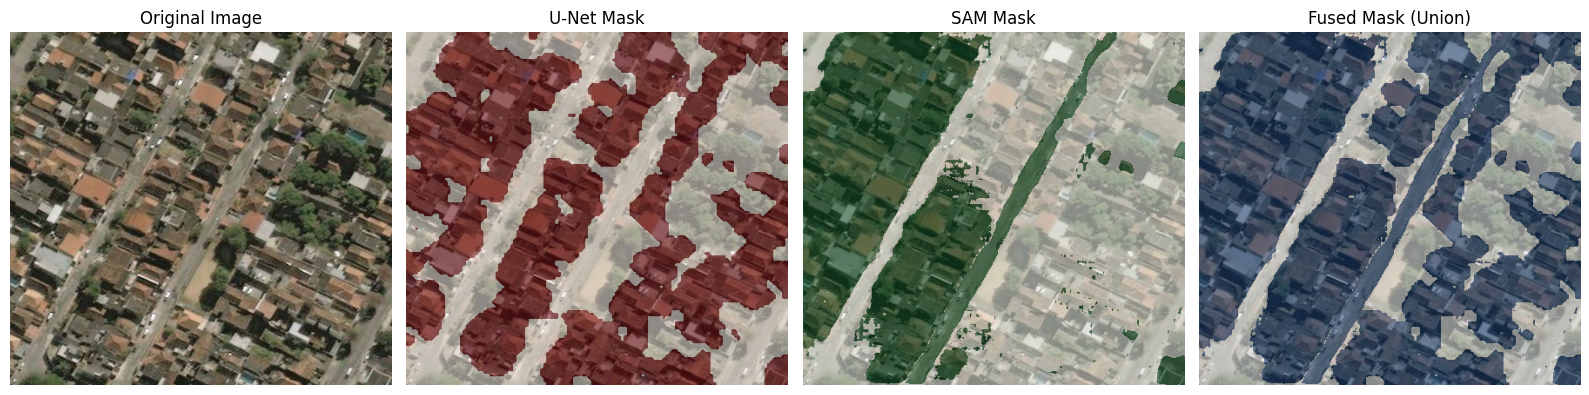

In [135]:
# Compare with union
union_mask = cv2.imread(f"/content/datasets/fused-masks/union/{base_name}.png", cv2.IMREAD_GRAYSCALE)
unionResult = (union_mask, "Fused Mask (Union)")
visualize_with_multiple_masks(
    image_path=image_path,
    mask1=mask1,
    mask2=mask2,
    mask3=unionResult
)

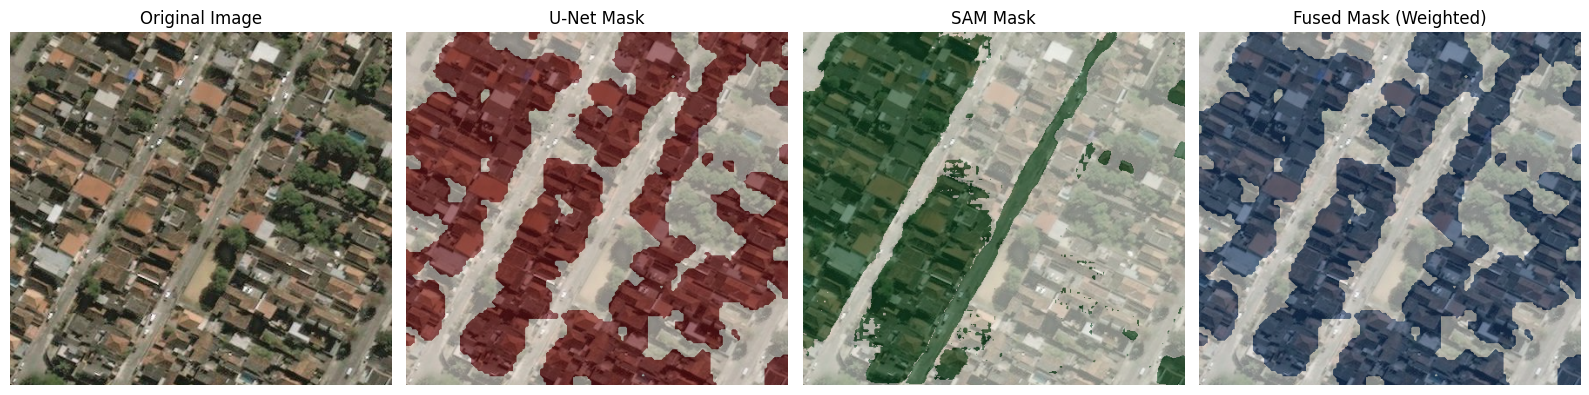

In [136]:
# Compare with weighted
weighted_mask = cv2.imread(f"/content/datasets/fused-masks/weighted/{base_name}.png", cv2.IMREAD_GRAYSCALE)
weightedResult = (weighted_mask, "Fused Mask (Weighted)")
visualize_with_multiple_masks(
    image_path=image_path,
    mask1=mask1,
    mask2=mask2,
    mask3=weightedResult
)

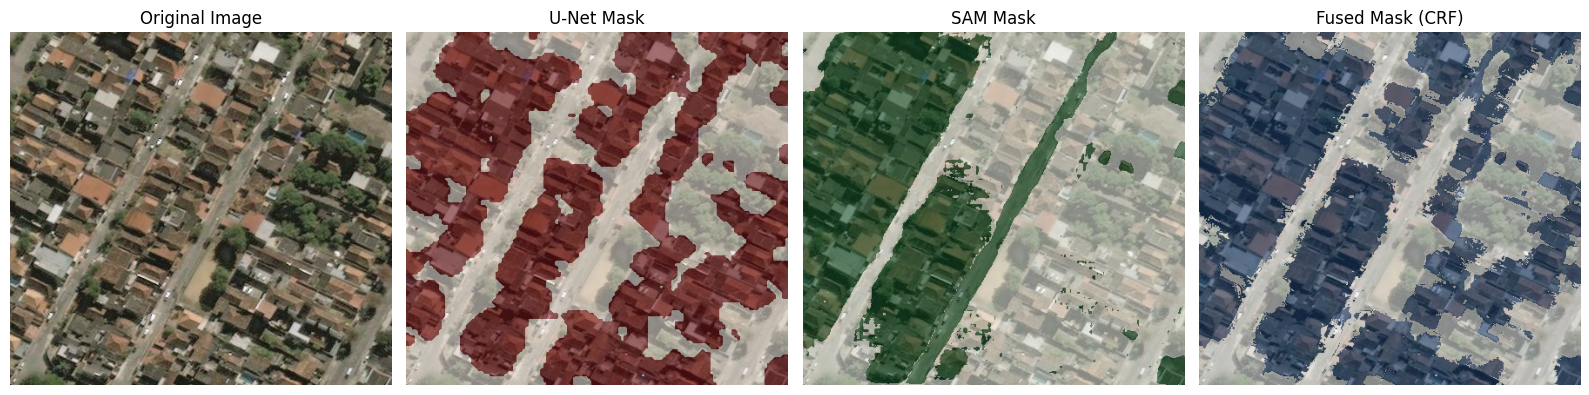

In [137]:
# Compare with CRF
crf_mask = cv2.imread(f"/content/datasets/fused-masks/crf/{base_name}.png", cv2.IMREAD_GRAYSCALE)
crfResult = (crf_mask, "Fused Mask (CRF)")
visualize_with_multiple_masks(
    image_path=image_path,
    mask1=mask1,
    mask2=mask2,
    mask3=crfResult
)

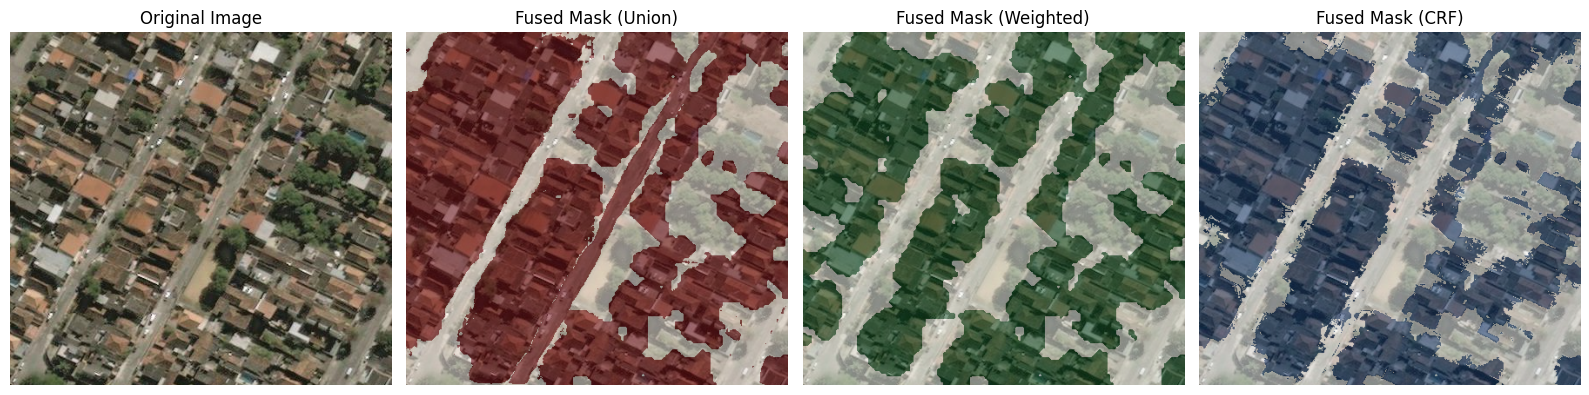

In [138]:
# Visualize all fusions
visualize_with_multiple_masks(
    image_path=image_path,
    mask1=unionResult,
    mask2=weightedResult,
    mask3=crfResult
)

# More testing

In [142]:
model_128_path = "/content/building_segmentation_model_3band_128_23-5.pth"

In [143]:
from models.unet.model import UNet
import torch

model_128 = UNet(num_classes=1, in_channels=3, depth=5)
model_128.load_state_dict(torch.load(model_path, map_location="cuda" if torch.cuda.is_available() else "cpu"))

model_128.eval()
model_128.to("cuda" if torch.cuda.is_available() else "cpu")

/content/models/unet/model.py:211: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  init.xavier_normal(m.weight)
/content/models/unet/model.py:212: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  init.constant(m.bias, 0)


UNet(
  (conv_final): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DownConv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): DownConv(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): DownConv(
      (conv1): Conv2d(256, 512, kernel_size=(3, 

In [204]:
from utils.Utilities import predict, save_prediction_as_png
from preprocess.CreateMaskRasterio import create_sam_mask
from ensemble.fusion import fusion
import cv2
from utils.Visualize import visualize_with_multiple_masks

## Testcase #1: img1784

In [192]:
!mkdir -p /content/test/img1784
!cp /content/datasets/test/3band/3band_AOI_2_RIO_img1784.tif /content/test/img1784/img1784.tif

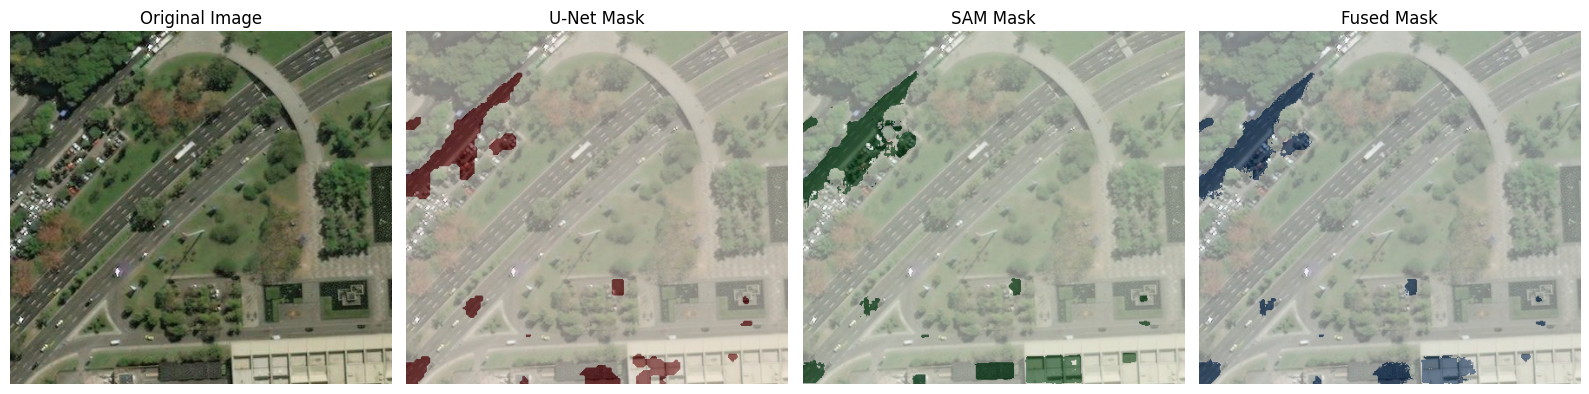

In [202]:
basename = "img1784"

# Create U-Net mask
image_path = f"/content/test/{basename}/{basename}.tif"
output128_dir = f"/content/test/{basename}/model128/"
unet128_mask = output128_dir + f"unet_{basename}.png"

os.makedirs(output128_dir, exist_ok=True)
prediction_128 = predict(model_128, image_path, 128, 128)
save_prediction_as_png(prediction_128, unet128_mask)

# Create SAM mask
sam128_mask = output128_dir + f"sam_{basename}.png"
create_sam_mask(predictor, image_path, unet128_mask, sam128_mask)

# Fusion U-Net mask and SAM mask
fusion(image_path, unet128_mask, sam128_mask, output128_dir)

# Visualize
unet_mask = cv2.imread(f"/content/test/{basename}/model128/unet_{basename}.png", cv2.IMREAD_GRAYSCALE)
sam_mask = cv2.imread(f"/content/test/{basename}/model128/sam_{basename}.png", cv2.IMREAD_GRAYSCALE)
fused_mask = cv2.imread(f"/content/test/{basename}/model128/crf_unet_{basename}.png", cv2.IMREAD_GRAYSCALE)

mask1 = (unet_mask, "U-Net Mask")
mask2 = (sam_mask, "SAM Mask")
mask3 = (fused_mask, "Fused Mask")

visualize_with_multiple_masks(image_path, mask1, mask2, mask3)

## Testcase #1: img1568

In [208]:
!mkdir -p /content/test/img1568
!cp /content/datasets/test/3band/3band_AOI_2_RIO_img1568.tif /content/test/img1568/img1568.tif

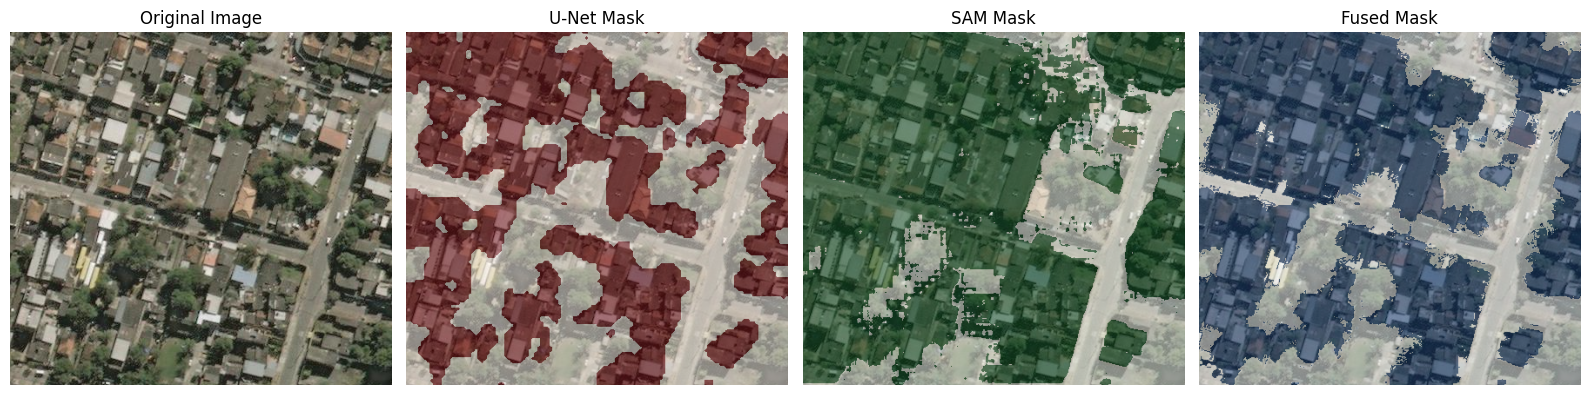

In [209]:
basename = "img1568"

# Create U-Net mask
image_path = f"/content/test/{basename}/{basename}.tif"
output128_dir = f"/content/test/{basename}/model128/"
unet128_mask = output128_dir + f"unet_{basename}.png"

os.makedirs(output128_dir, exist_ok=True)
prediction_128 = predict(model_128, image_path, 128, 128)
save_prediction_as_png(prediction_128, unet128_mask)

# Create SAM mask
sam128_mask = output128_dir + f"sam_{basename}.png"
create_sam_mask(predictor, image_path, unet128_mask, sam128_mask)

# Fusion U-Net mask and SAM mask
fusion(image_path, unet128_mask, sam128_mask, output128_dir)

# Visualize
unet_mask = cv2.imread(f"/content/test/{basename}/model128/unet_{basename}.png", cv2.IMREAD_GRAYSCALE)
sam_mask = cv2.imread(f"/content/test/{basename}/model128/sam_{basename}.png", cv2.IMREAD_GRAYSCALE)
fused_mask = cv2.imread(f"/content/test/{basename}/model128/crf_unet_{basename}.png", cv2.IMREAD_GRAYSCALE)

mask1 = (unet_mask, "U-Net Mask")
mask2 = (sam_mask, "SAM Mask")
mask3 = (fused_mask, "Fused Mask")

visualize_with_multiple_masks(image_path, mask1, mask2, mask3)